In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter('ignore')

sys.path.append('../../utilities')
sys.path.append('../../models/grt123')
sys.path.append('../../models/grt123/training')
sys.path.append('../../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import SummitScan, xyz2irc
from evaluation import noduleCADEvaluation

workspace_path = Path(os.getcwd()).parent.parent


# Test Balanced Data

# Scan Metadata

In [2]:

from yaml import scan


def set_is_actionable(row):
    if row['radiology_report_management_plan_final'] in ['3_MONTH_FOLLOW_UP_SCAN','URGENT_REFERRAL', 'ALWAYS_SCAN_AT_YEAR_1']:
        return 'Actonable'
    else:
        return 'Non-Actionable'

def set_smoking_pack_years_cats(df):
    df[df['smoking_pack_years'] < 0] = np.nan
    return pd.qcut(df['smoking_pack_years'], 3, labels=['Low (15-35)', 'Medium (35-50)', 'High (50+)'])

person_data = pd.read_csv(
    f'{workspace_path}/data/summit/data/person_data.csv',
    usecols=['LDCT_RADIOLOGY_REPORT_main_participant_id', 'lung_health_check_clinical_smoking_pack_years', 'ocd_DeprivationScore_IMDRank']
).rename(columns={
    'lung_health_check_clinical_smoking_pack_years':'smoking_pack_years',
    'ocd_DeprivationScore_IMDRank':'deprivation_score'
}).assign(
    smoking_pack_years_cats=lambda df: set_smoking_pack_years_cats(df),
    IMDRank_tertile=lambda df: pd.qcut(df['deprivation_score'], 3, labels=['Low', 'Medium', 'High']),
    IMDRank_quintile=lambda df: pd.qcut(df['deprivation_score'], 5, labels=['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']),
)
                          
scan_metadata = (
    pd.read_csv(f'{workspace_path}/metadata/summit/perifissural_only/test_scans_metadata.csv')
    .assign(name=lambda df: df['LDCT_RADIOLOGY_REPORT_main_participant_id'] + '_Y0_BASELINE_A')
    .assign(is_actionable=lambda df: df.apply(set_is_actionable, axis=1))
    .assign(gender_is_actionable=lambda df: df.apply(set_gender_is_actionable, axis=1))    
    .assign(gender_is_not_actionable=lambda df: df.apply(set_gender_is_not_actionable, axis=1))    
    .assign(ethnic_group_is_actionable=lambda df: df.apply(set_ethnic_group_is_actionable, axis=1))    
    .assign(ethnic_group_is_not_actionable=lambda df: df.apply(set_ethnic_group_is_not_actionable, axis=1))    
    .rename(columns={
        'participant_details_gender':'gender',
        'lung_health_check_demographics_race_ethnicgroup':'ethnic_group'
    })
).merge(person_data, on='LDCT_RADIOLOGY_REPORT_main_participant_id')
scan_metadata = (
    scan_metadata
    .assign(smoking_pack_years_is_actionable=lambda df: df.apply(set_smoking_pack_years_is_actionable, axis=1))
    .assign(imdrank_is_actionable=lambda df: df.apply(set_imdrank_is_actionable, axis=1))    
)

## GRT123

In [5]:
# Add in diameter cuts for later analysis
def combine_site(nodule_site):
    if nodule_site.find('UPPER') > -1:
        return 'UPPER'
    elif nodule_site.find('NOT') > -1:
        return 'NOT_ANSWERED'
    else:
        return 'NOT-UPPER'
    
def combine_site2(nodule_site):
    if nodule_site.find('RIGHT') > -1:
        return 'RIGHT'
    elif nodule_site.find('LEFT') > -1:
        return 'LEFT'
    else:
        return 'NOT_ANSWERED'
    

diameter_cats = [0, 4, 8, 15, 20, 30, 40, 999]
diameter_lbs = [f'{diameter_cats[i]:02}-{diameter_cats[i+1]:02}' for i in range(len(diameter_cats))[:-1]]

In [ ]:



annotations = (
    pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_metadata.csv')
    .assign(diameter_cats=lambda df: 
        pd.cut(
            df['nodule_diameter_mm'], 
            bins=diameter_cats,
            labels=diameter_lbs
        )            
    )
    .assign(nodule_site_combined=lambda df: df['nodule_site'].apply(combine_site))
    .assign(nodule_site_combined2=lambda df: df['nodule_site'].apply(combine_site2))
)

display(annotations.nodule_site_combined.value_counts())

# save back to the metadata file
annotations.to_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_metadata.csv', index=False)
grt123_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_metadata.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/perifissural_only/test_scans.csv',
    results_filename=f"{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_predictions.csv",    
    filter='\nModel 1 trained on Test Balanced SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/froc_perifissural_only_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/CADAnalysis.txt')

### Gender analysis

In [ ]:

annotations_excluded = pd.read_csv(f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv')

annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_metadata.csv')

predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_predictions.csv')

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### Ethnicity analysis

In [ ]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### IMDRank_tertile

In [ ]:
protected_group = 'IMDRank_tertile'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### Smoking Pack Years


In [ ]:
protected_group = 'smoking_pack_years_cats'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable Vs Non-Actionable

In [ ]:
protected_group = 'is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable-Gender Splits

In [ ]:
protected_group = 'gender_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### NonActionable-Gender

In [ ]:
protected_group = 'gender_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable Ethnic Group

In [ ]:
protected_group = 'ethnic_group_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### NonActionable Ethnic Group

In [ ]:
protected_group = 'ethnic_group_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable IMDRank

In [ ]:
protected_group = 'imdrank_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable Smoking Status

In [ ]:
protected_group = 'smoking_pack_years_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/perifissural_only/{protected_group}'
)

### False positive and Miss Investigations

In [ ]:
import importlib
import utils

importlib.reload(utils)

In [ ]:
thresholds = utils.get_thresholds(grt123_summit_summit)
missed_metadata = utils.miss_anaysis_at_fpps(
    model='grt123',
    scans_metadata=scan_metadata,
    scans_path=f'{workspace_path}/metadata/summit/perifissural_only/test_scans.csv',
    annotations_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_metadata.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    predictions_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_predictions.csv',
    thresholds=thresholds
)


#### Incremental FROC Scores - Gender/ Ethnic Group/ Nodule Type

In [ ]:

hit_and_miss_dict = utils.get_protected_group_by_nodule_type(missed_metadata)


In [ ]:


recode_dict = {}
for idx in range(7):
    hmm = {}
    for slice in ['all','actionable']:
        for protected_group in ['MALE','FEMALE','All', 'Asian or Asian British', 'Black', 'White']:
            for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:
            
                try:

                    group = 'gender' if protected_group in ['MALE','FEMALE','All'] else 'ethnic_group'

                    total = hit_and_miss_dict[idx][slice][group][(True,type)][protected_group] + hit_and_miss_dict[idx][slice][group][(False,type)][protected_group]
                    hits = hit_and_miss_dict[idx][slice][group][(False,type)][protected_group]
                    perc_hits = round(100 * (hits/total),0)

                    hmm[f'{slice}_{protected_group}_{type}_Hits%'] = perc_hits
                except:
                    print(f'Error: {idx}, {slice}, {protected_group}, {type}')
                    pass

    recode_dict[idx] = hmm

df = pd.DataFrame.from_dict(recode_dict, orient='index')

# Remove ".0" from each value in the dataframe
df = df.applymap(lambda x: str(x).replace('.0', ''))

# Collapse each column into comma-delimited values
collapsed_df = df.apply(lambda x: ', '.join(x), axis=0)

display(collapsed_df)

from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def calculate_significant_differences(df, group1_name, group2_name):

    group1 = df[group1_name].astype(int).values
    group2 = df[group2_name].astype(int).values

    shapiro_group1 = shapiro(group1)
    shapiro_group2 = shapiro(group2)

    print('*'*50)
    if shapiro_group1[1] > 0.05 and shapiro_group2[1] > 0.05:
        t_test = ttest_ind(group1, group2)
        print(f'Independent T-Test: {round(t_test.statistic,3)}, {round(t_test.pvalue,3)}')
    else:
        manwhitney = mannwhitneyu(group1, group2)
        print(f'Mann-Whitney U Test: {round(manwhitney.statistic,3)}, {round(manwhitney.pvalue,3)}')

for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:

    print(f'*** {type} ***')
    group1 = f'all_White_{type}_Hits%'
    group2 = f'all_Asian or Asian British_{type}_Hits%'
    calculate_significant_differences(df, group1, group2)

#### Nodule Characteristic Analysis

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

nodule_characteristics = {
    'nodule_site_combined2': ['RIGHT', 'LEFT', 'NOT_ANSWERED'],
    'nodule_site_combined': ['UPPER','NOT-UPPER', 'NOT_ANSWERED'],
    'nodule_type': ['SOLID', 'NON_SOLID', 'PART_SOLID', 'PERIFISSURAL', 'CALCIFIED'],
    'management_plan': ['RANDOMISATION_AT_YEAR_1','ALWAYS_SCAN_AT_YEAR_1', '3_MONTH_FOLLOW_UP_SCAN', 'URGENT_REFERRAL'],
    'diameter_cats': diameter_lbs,
}

for ivx, (var, order) in enumerate(nodule_characteristics.items()):
    annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_metadata.csv')
    # annotations = annotations[annotations['management_plan'] != 'RANDOMISATION_AT_YEAR_1']

    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []

    for idx, metadata in enumerate(missed_metadata):
        results.append(
            pd.crosstab(
                metadata[var], 
                metadata['miss'],
                normalize='index'
            )[False]
            .rename(f'{operating_points[idx]}')
            .reindex(order)
            
        )

    df = pd.concat(results, axis=1).fillna(0).round(2).merge(total_vc.to_frame(), left_index=True, right_index=True)

    display(df.T)


    line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
    weights = df.pop('Total Annotations')

    for isx, column in enumerate(df.T):    
            ax[ivx].plot(df.T[column], label=column, linestyle=line_styles[isx], linewidth=weights[isx]/100)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('% of Hits')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Hits at Different FPPs')
plt.show()

In [ ]:
missed_at_lowest = missed_metadata[0]
hits = missed_at_lowest[missed_at_lowest['miss'] == False]

(
    pd.crosstab(
        [
            hits['diameter_cats'],
            hits['nodule_type']
        ], 
        hits['nodule_site_combined'],
        normalize='all'
    )[['UPPER','NOT-UPPER']]
    .apply(lambda x: round(100 * x, 1))
)

In [ ]:
thresholds = get_thresholds(grt123_summit_summit)

scans = pd.read_csv(f'{workspace_path}/metadata/summit/perifissural_only/test_scans.csv')
predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_predictions.csv')
annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/perifissural_only/perifissural_only_metadata.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,    
    predictions=predictions,
    annotations=annotations
)

#### Examples of False Positives

In [ ]:
cnt = 0

df = false_positives_fpps['0.125']

for idx, row in df[df.distance_false_positive].sort_values(by='threshold', ascending=False).iterrows():
    study_id = row['name']
    x = row['row']
    y = row['col']
    z = row['index']
    diameter = row['diameter']
    

    copy_scan_from_cluster(study_id)
    show_numpy_candidate_location(study_id, x, y, z, diameter, row.distance_false_positive, row.iou_false_positive)
    cnt+=1
    if cnt == 12:
        break

## MONAI Detection

/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/perifissural_only/result_perifissural_only.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv
Total number of included nodule annotations: 788
Total number of nodule annotations: 788
Cases: 1189
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule An

100%|██████████| 1000/1000 [01:38<00:00, 10.14it/s]


0                  159                476   \
0  0.08 (0.06 - 0.11)  0.2 (0.15 - 0.25)  0.36 (0.32 - 0.4)   

                1111               2381               4920                9999  
0  0.6 (0.55 - 0.64)  0.76 (0.73 - 0.8)  0.88 (0.85 - 0.9)  0.94 (0.93 - 0.96)

fps  mean_sens  low_sens  high_sens
0     0.12       0.08      0.06       0.11
159   0.25       0.20      0.15       0.25
476   0.50       0.36      0.32       0.40
1111  1.00       0.60      0.55       0.64
2381  2.00       0.76      0.73       0.80
4920  4.00       0.88      0.85       0.90
9999  8.00       0.94      0.93       0.96

Mean Sensitivity: 0.55 Low Sensitivity: 0.51 High Sensitivity: 0.58


True positives        778
0                                    False positives  60536.000
1                                    False negatives     10.000
2                                     True negatives      0.000
3                         Total number of candidates  62034.000
4                            Total number of nodules    788.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    726.000
7                                        Sensitivity      0.987
8              Average number of candidates per scan     52.173

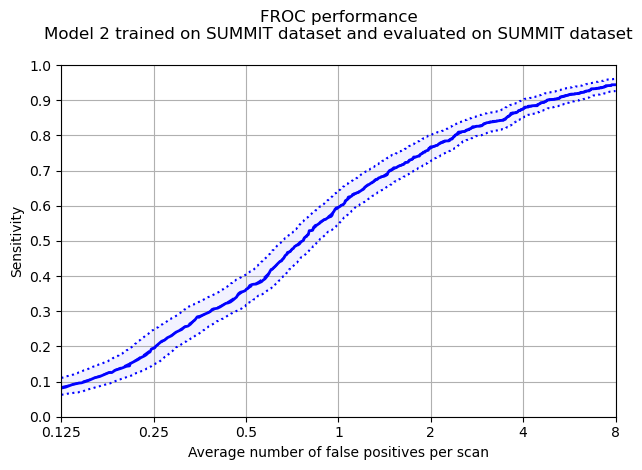

In [6]:

detection_predictions_path = combine_predictions(f'{workspace_path}/models/detection/result/trained_summit/summit/perifissural_only', 'test')
detection_predictions = pd.read_csv(detection_predictions_path)

annotations = (
    pd.read_csv(f'{workspace_path}/metadata/summit/perifissural_only/test_metadata.csv')
    .assign(name=lambda df: df.participant_id + '_Y0_BASELINE_A')
    .assign(row=lambda df: df['nodule_x_coordinate'])
    .assign(col=lambda df: df['nodule_y_coordinate'])
    .assign(index=lambda df: df['nodule_z_coordinate'])
    .assign(diameter=lambda df: df['nodule_diameter_mm'])
    .assign(diameter_cats=lambda df: pd.cut(
        df['nodule_diameter_mm'],
        bins=diameter_cats,
        labels=diameter_lbs
    ))
    .assign(nodule_site_combined=lambda df: df['nodule_site'].apply(combine_site))
    .assign(nodule_site_combined2=lambda df: df['nodule_site'].apply(combine_site2))
)

annotations.to_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv', index=False)

detection_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/perifissural_only/test_scans.csv',
    results_filename=detection_predictions_path,
    filter='\nModel 2 trained on SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/froc_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/CADAnalysis.txt')


### Gender analysis

Protected Group: FEMALE


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpha7x0z1z/annotations.csv
Total number of included nodule annotations: 297
Total number of nodule annotations: 297
Cases: 479
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:25<00:00, 38.85it/s]


0                  159                 476   \
0  0.05 (0.03 - 0.1)  0.2 (0.13 - 0.27)  0.38 (0.31 - 0.47)   

                1111                2381                4920  \
0  0.64 (0.58 - 0.7)  0.79 (0.73 - 0.84)  0.88 (0.85 - 0.92)   

                 9999  
0  0.95 (0.92 - 0.97)

fps  mean_sens  low_sens  high_sens
0     0.12       0.05      0.03       0.10
159   0.25       0.20      0.13       0.27
476   0.50       0.38      0.31       0.47
1111  1.00       0.64      0.58       0.70
2381  2.00       0.79      0.73       0.84
4920  4.00       0.88      0.85       0.92
9999  8.00       0.95      0.92       0.97

Mean Sensitivity: 0.56 Low Sensitivity: 0.51 High Sensitivity: 0.61


True positives        295
0                                    False positives  22411.000
1                                    False negatives      2.000
2                                     True negatives      0.000
3                         Total number of candidates  22994.000
4                            Total number of nodules    297.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    292.000
7                                        Sensitivity      0.993
8              Average number of candidates per scan     48.004

Protected Group: MALE


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpgs6g483m/annotations.csv
Total number of included nodule annotations: 474
Total number of nodule annotations: 474
Cases: 693


100%|██████████| 1000/1000 [00:50<00:00, 19.83it/s]


0                  159                476                1111  \
0  0.1 (0.07 - 0.14)  0.2 (0.15 - 0.25)  0.35 (0.3 - 0.41)  0.56 (0.5 - 0.63)   

               2381               4920                9999  
0  0.75 (0.7 - 0.8)  0.86 (0.82 - 0.9)  0.95 (0.93 - 0.97)

fps  mean_sens  low_sens  high_sens
0     0.12       0.10      0.07       0.14
159   0.25       0.20      0.15       0.25
476   0.50       0.35      0.30       0.41
1111  1.00       0.56      0.50       0.63
2381  2.00       0.75      0.70       0.80
4920  4.00       0.86      0.82       0.90
9999  8.00       0.95      0.93       0.97

Mean Sensitivity: 0.54 Low Sensitivity: 0.5 High Sensitivity: 0.59


True positives        467
0                                    False positives  37226.000
1                                    False negatives      7.000
2                                     True negatives      0.000
3                         Total number of candidates  38113.000
4                            Total number of nodules    474.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    420.000
7                                        Sensitivity      0.985
8              Average number of candidates per scan     54.997

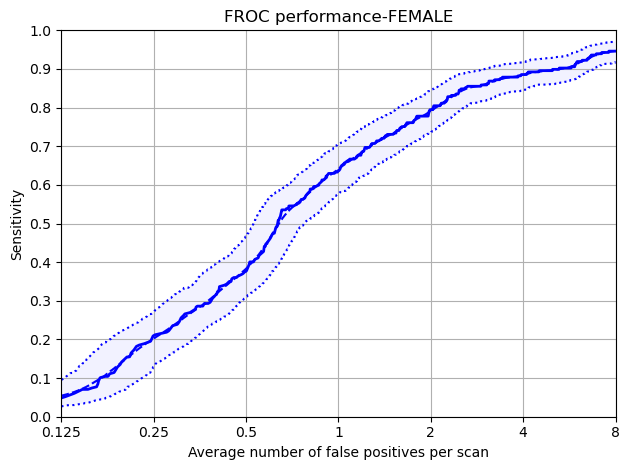

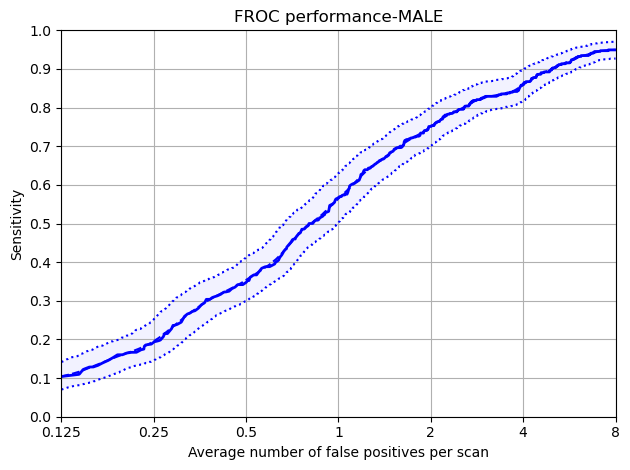

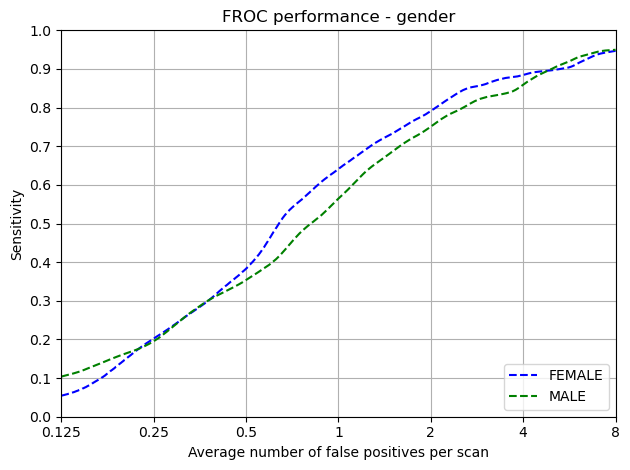

In [8]:

annotations_excluded = pd.read_csv(f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv')

annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv')

predictions = pd.read_csv(detection_predictions_path)

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)

### Ethnicity Analysis

Protected Group: White


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp6_9bzn8y/annotations.csv
Total number of included nodule annotations: 596
Total number of nodule annotations: 596
Cases: 870
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [01:03<00:00, 15.66it/s]


0                   159                 476   \
0  0.08 (0.05 - 0.11)  0.18 (0.12 - 0.25)  0.36 (0.31 - 0.42)   

                 1111               2381               4920  \
0  0.59 (0.54 - 0.64)  0.75 (0.7 - 0.79)  0.87 (0.84 - 0.9)   

                 9999  
0  0.95 (0.93 - 0.97)

fps  mean_sens  low_sens  high_sens
0     0.12       0.08      0.05       0.11
159   0.25       0.18      0.12       0.25
476   0.50       0.36      0.31       0.42
1111  1.00       0.59      0.54       0.64
2381  2.00       0.75      0.70       0.79
4920  4.00       0.87      0.84       0.90
9999  8.00       0.95      0.93       0.97

Mean Sensitivity: 0.54 Low Sensitivity: 0.5 High Sensitivity: 0.58


True positives        591
0                                    False positives  46817.000
1                                    False negatives      5.000
2                                     True negatives      0.000
3                         Total number of candidates  47953.000
4                            Total number of nodules    596.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    549.000
7                                        Sensitivity      0.992
8              Average number of candidates per scan     55.118

Protected Group: Asian or Asian British


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpfolp6x9b/annotations.csv
Total number of included nodule annotations: 82
Total number of nodule annotations: 82
Cases: 135


100%|██████████| 1000/1000 [00:05<00:00, 177.98it/s]


0                  159                476   \
0  0.06 (0.0 - 0.18)  0.15 (0.05 - 0.3)  0.3 (0.19 - 0.43)   

                 1111                2381                4920  \
0  0.56 (0.37 - 0.72)  0.75 (0.64 - 0.86)  0.86 (0.76 - 0.94)   

                 9999  
0  0.92 (0.85 - 0.98)

fps  mean_sens  low_sens  high_sens
0     0.12       0.06      0.00       0.18
159   0.25       0.15      0.05       0.30
476   0.50       0.30      0.19       0.43
1111  1.00       0.56      0.37       0.72
2381  2.00       0.75      0.64       0.86
4920  4.00       0.86      0.76       0.94
9999  8.00       0.92      0.85       0.98

Mean Sensitivity: 0.51 Low Sensitivity: 0.41 High Sensitivity: 0.63


True positives        79
0                                    False positives  5917.000
1                                    False negatives     3.000
2                                     True negatives     0.000
3                         Total number of candidates  6065.000
4                            Total number of nodules    82.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    69.000
7                                        Sensitivity     0.963
8              Average number of candidates per scan    44.926

Protected Group: Other ethnic groups


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp7fbcsd53/annotations.csv
Total number of included nodule annotations: 22
Total number of nodule annotations: 22
Cases: 41


100%|██████████| 1000/1000 [00:01<00:00, 508.71it/s]


0                   159                 476   \
0  0.28 (0.04 - 0.52)  0.37 (0.16 - 0.56)  0.42 (0.23 - 0.64)   

               1111              2381               4920               9999  
0  0.7 (0.45 - 0.9)  0.9 (0.75 - 1.0)  0.95 (0.82 - 1.0)  0.95 (0.83 - 1.0)

fps  mean_sens  low_sens  high_sens
0     0.12       0.28      0.04       0.52
159   0.25       0.37      0.16       0.56
476   0.50       0.42      0.23       0.64
1111  1.00       0.70      0.45       0.90
2381  2.00       0.90      0.75       1.00
4920  4.00       0.95      0.82       1.00
9999  8.00       0.95      0.83       1.00

Mean Sensitivity: 0.65 Low Sensitivity: 0.47 High Sensitivity: 0.8


True positives        22
0                                    False positives  1787.000
1                                    False negatives     0.000
2                                     True negatives     0.000
3                         Total number of candidates  1834.000
4                            Total number of nodules    22.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    25.000
7                                        Sensitivity     1.000
8              Average number of candidates per scan    44.732

Protected Group: Black


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpdlh6ckwr/annotations.csv
Total number of included nodule annotations: 62
Total number of nodule annotations: 62
Cases: 101


100%|██████████| 1000/1000 [00:03<00:00, 258.05it/s]


0                   159                 476   \
0  0.2 (0.1 - 0.33)  0.25 (0.13 - 0.41)  0.48 (0.27 - 0.66)   

                 1111                2381                4920  \
0  0.76 (0.63 - 0.88)  0.81 (0.71 - 0.91)  0.93 (0.85 - 0.98)   

                 9999  
0  0.93 (0.86 - 0.99)

fps  mean_sens  low_sens  high_sens
0     0.12       0.20      0.10       0.33
159   0.25       0.25      0.13       0.41
476   0.50       0.48      0.27       0.66
1111  1.00       0.76      0.63       0.88
2381  2.00       0.81      0.71       0.91
4920  4.00       0.93      0.85       0.98
9999  8.00       0.93      0.86       0.99

Mean Sensitivity: 0.62 Low Sensitivity: 0.51 High Sensitivity: 0.74


True positives        61
0                                    False positives  3950.000
1                                    False negatives     1.000
2                                     True negatives     0.000
3                         Total number of candidates  4072.000
4                            Total number of nodules    62.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    61.000
7                                        Sensitivity     0.984
8              Average number of candidates per scan    40.317

Protected Group: Mixed


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp79n0qrvh/annotations.csv
Total number of included nodule annotations: 9
Total number of nodule annotations: 9
Cases: 28


100%|██████████| 1000/1000 [00:01<00:00, 707.44it/s]


0                159               476               1111  \
0  nan (0.0 - 0.67)  nan (0.0 - 0.8)  nan (0.0 - 0.86)  nan (0.25 - 1.0)   

              2381             4920             9999  
0  nan (0.5 - 1.0)  nan (0.5 - 1.0)  nan (0.6 - 1.0)

fps  mean_sens  low_sens  high_sens
0     0.12        NaN      0.00       0.67
159   0.25        NaN      0.00       0.80
476   0.50        NaN      0.00       0.86
1111  1.00        NaN      0.25       1.00
2381  2.00        NaN      0.50       1.00
4920  4.00        NaN      0.50       1.00
9999  8.00        NaN      0.60       1.00

Mean Sensitivity: nan Low Sensitivity: 0.26 High Sensitivity: 0.9


True positives        9
0                                    False positives  1166.00
1                                    False negatives     0.00
2                                     True negatives     0.00
3                         Total number of candidates  1183.00
4                            Total number of nodules     9.00
5             Ignored candidates on excluded nodules     0.00
6      Ignored candidates which were double detec...     8.00
7                                        Sensitivity     1.00
8              Average number of candidates per scan    42.25

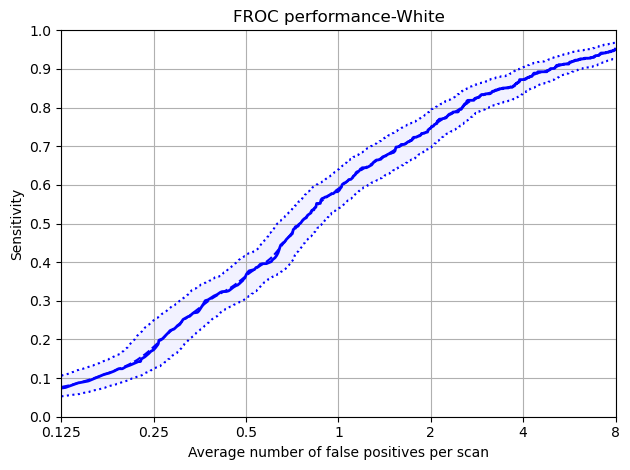

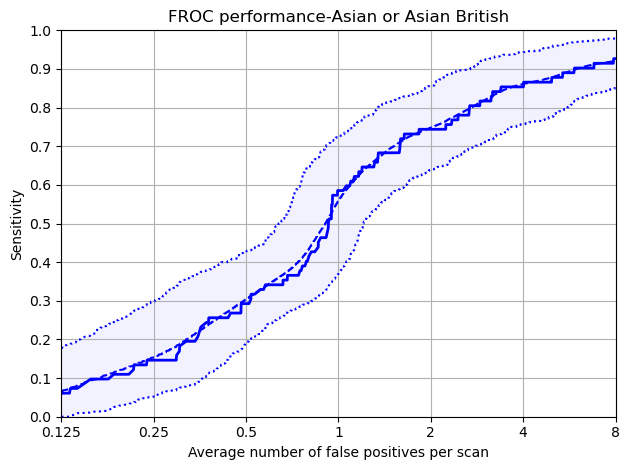

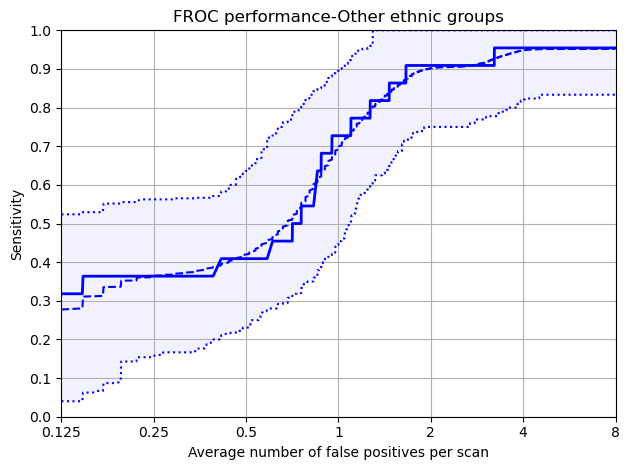

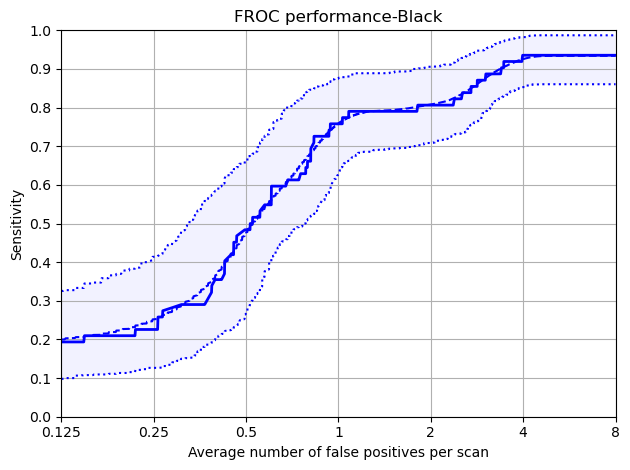

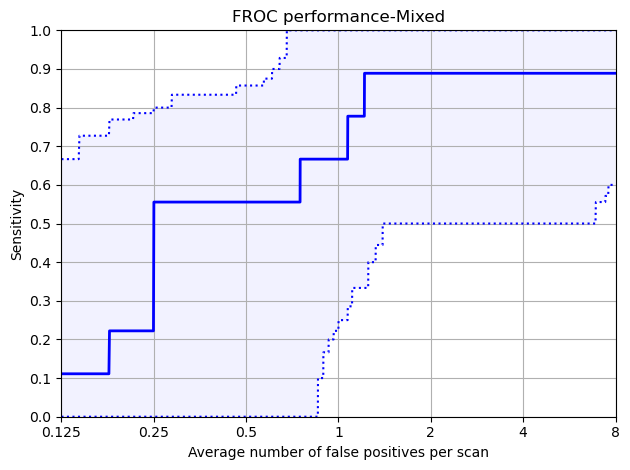

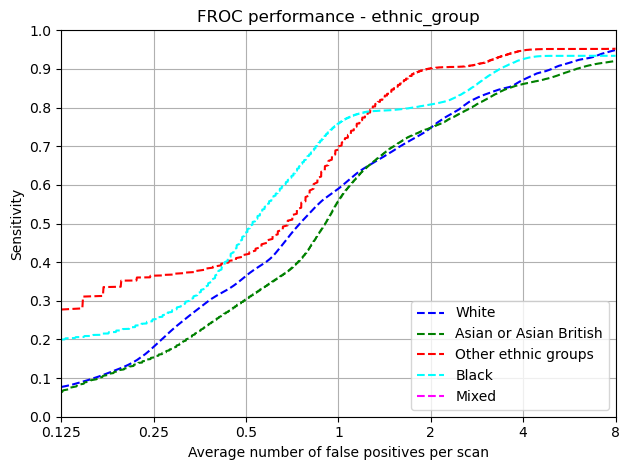

In [9]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)

### IMDRank_tertile

Protected Group: Low


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpd9vrp7c7/annotations.csv
Total number of included nodule annotations: 228
Total number of nodule annotations: 228
Cases: 373


100%|██████████| 1000/1000 [00:19<00:00, 51.68it/s]


0                   159                476   \
0  0.08 (0.04 - 0.13)  0.18 (0.11 - 0.25)  0.32 (0.25 - 0.4)   

                 1111               2381                4920  \
0  0.59 (0.52 - 0.66)  0.74 (0.68 - 0.8)  0.85 (0.79 - 0.91)   

                 9999  
0  0.94 (0.91 - 0.97)

fps  mean_sens  low_sens  high_sens
0     0.12       0.08      0.04       0.13
159   0.25       0.18      0.11       0.25
476   0.50       0.32      0.25       0.40
1111  1.00       0.59      0.52       0.66
2381  2.00       0.74      0.68       0.80
4920  4.00       0.85      0.79       0.91
9999  8.00       0.94      0.91       0.97

Mean Sensitivity: 0.53 Low Sensitivity: 0.47 High Sensitivity: 0.59


True positives        225
0                                    False positives  19217.000
1                                    False negatives      3.000
2                                     True negatives      0.000
3                         Total number of candidates  19657.000
4                            Total number of nodules    228.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    215.000
7                                        Sensitivity      0.987
8              Average number of candidates per scan     52.700

Protected Group: Medium


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp63hj3y3g/annotations.csv
Total number of included nodule annotations: 282
Total number of nodule annotations: 282
Cases: 422
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:21<00:00, 46.17it/s]


0                  159                 476   \
0  0.08 (0.03 - 0.13)  0.2 (0.13 - 0.27)  0.36 (0.27 - 0.45)   

                 1111                2381                4920  \
0  0.57 (0.48 - 0.67)  0.77 (0.71 - 0.83)  0.88 (0.84 - 0.92)   

                9999  
0  0.93 (0.9 - 0.96)

fps  mean_sens  low_sens  high_sens
0     0.12       0.08      0.03       0.13
159   0.25       0.20      0.13       0.27
476   0.50       0.36      0.27       0.45
1111  1.00       0.57      0.48       0.67
2381  2.00       0.77      0.71       0.83
4920  4.00       0.88      0.84       0.92
9999  8.00       0.93      0.90       0.96

Mean Sensitivity: 0.54 Low Sensitivity: 0.48 High Sensitivity: 0.6


True positives        278
0                                    False positives  21294.000
1                                    False negatives      4.000
2                                     True negatives      0.000
3                         Total number of candidates  21822.000
4                            Total number of nodules    282.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    254.000
7                                        Sensitivity      0.986
8              Average number of candidates per scan     51.711

Protected Group: High


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpslpb23vx/annotations.csv
Total number of included nodule annotations: 259
Total number of nodule annotations: 259
Cases: 367


100%|██████████| 1000/1000 [00:20<00:00, 49.48it/s]


0                   159                476   \
0  0.1 (0.06 - 0.16)  0.19 (0.12 - 0.32)  0.4 (0.33 - 0.47)   

                1111                2381                4920  \
0  0.63 (0.55 - 0.7)  0.79 (0.71 - 0.85)  0.89 (0.85 - 0.93)   

                 9999  
0  0.96 (0.94 - 0.99)

fps  mean_sens  low_sens  high_sens
0     0.12       0.10      0.06       0.16
159   0.25       0.19      0.12       0.32
476   0.50       0.40      0.33       0.47
1111  1.00       0.63      0.55       0.70
2381  2.00       0.79      0.71       0.85
4920  4.00       0.89      0.85       0.93
9999  8.00       0.96      0.94       0.99

Mean Sensitivity: 0.57 Low Sensitivity: 0.51 High Sensitivity: 0.63


True positives        257
0                                    False positives  18650.000
1                                    False negatives      2.000
2                                     True negatives      0.000
3                         Total number of candidates  19149.000
4                            Total number of nodules    259.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    242.000
7                                        Sensitivity      0.992
8              Average number of candidates per scan     52.177

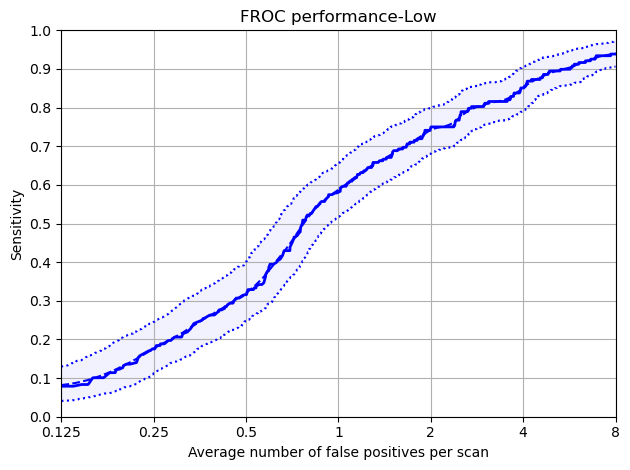

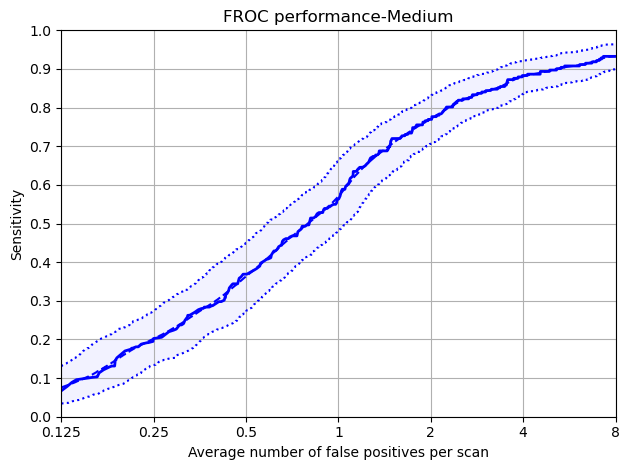

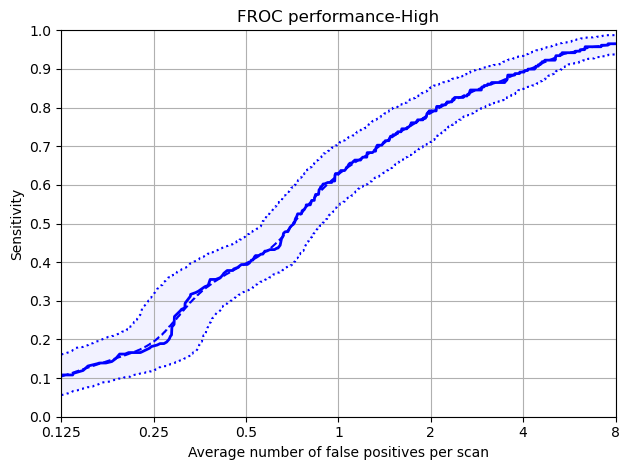

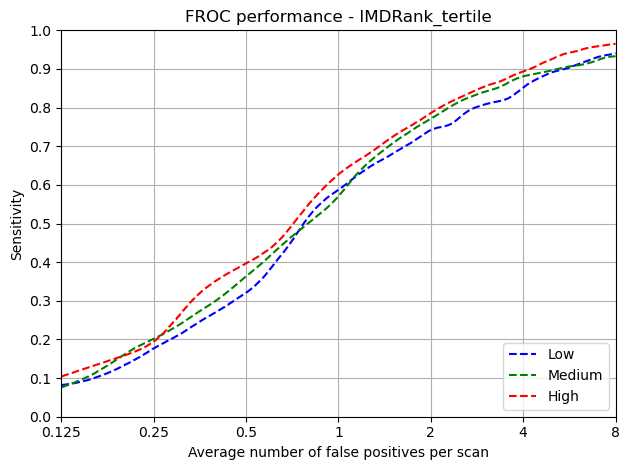

In [10]:
protected_group = 'IMDRank_tertile'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)

### Smoking Pack Years


Protected Group: Medium (35-50)


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpfpj5h18p/annotations.csv
Total number of included nodule annotations: 252
Total number of nodule annotations: 252
Cases: 400
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:21<00:00, 46.36it/s]


0                   159                476   \
0  0.1 (0.05 - 0.15)  0.24 (0.13 - 0.36)  0.42 (0.34 - 0.5)   

                 1111                2381                4920  \
0  0.65 (0.57 - 0.73)  0.83 (0.78 - 0.88)  0.93 (0.89 - 0.96)   

                 9999  
0  0.97 (0.95 - 0.99)

fps  mean_sens  low_sens  high_sens
0     0.12       0.10      0.05       0.15
159   0.25       0.24      0.13       0.36
476   0.50       0.42      0.34       0.50
1111  1.00       0.65      0.57       0.73
2381  2.00       0.83      0.78       0.88
4920  4.00       0.93      0.89       0.96
9999  8.00       0.97      0.95       0.99

Mean Sensitivity: 0.59 Low Sensitivity: 0.53 High Sensitivity: 0.65


True positives        252
0                                    False positives  19889.000
1                                    False negatives      0.000
2                                     True negatives      0.000
3                         Total number of candidates  20399.000
4                            Total number of nodules    252.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    262.000
7                                        Sensitivity      1.000
8              Average number of candidates per scan     50.998

Protected Group: High (50+)


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp0kheul3s/annotations.csv
Total number of included nodule annotations: 258
Total number of nodule annotations: 258
Cases: 381


100%|██████████| 1000/1000 [00:21<00:00, 47.33it/s]


0                   159                476   \
0  0.05 (0.02 - 0.1)  0.14 (0.09 - 0.21)  0.26 (0.2 - 0.34)   

                 1111                2381                4920  \
0  0.49 (0.41 - 0.56)  0.68 (0.61 - 0.75)  0.82 (0.76 - 0.89)   

                9999  
0  0.93 (0.9 - 0.96)

fps  mean_sens  low_sens  high_sens
0     0.12       0.05      0.02       0.10
159   0.25       0.14      0.09       0.21
476   0.50       0.26      0.20       0.34
1111  1.00       0.49      0.41       0.56
2381  2.00       0.68      0.61       0.75
4920  4.00       0.82      0.76       0.89
9999  8.00       0.93      0.90       0.96

Mean Sensitivity: 0.48 Low Sensitivity: 0.43 High Sensitivity: 0.54


True positives        253
0                                    False positives  20414.000
1                                    False negatives      5.000
2                                     True negatives      0.000
3                         Total number of candidates  20865.000
4                            Total number of nodules    258.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    198.000
7                                        Sensitivity      0.981
8              Average number of candidates per scan     54.764

Protected Group: Low (15-35)


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmprt114jnn/annotations.csv
Total number of included nodule annotations: 261
Total number of nodule annotations: 261
Cases: 392


100%|██████████| 1000/1000 [00:20<00:00, 47.86it/s]


0                   159                 476   \
0  0.12 (0.07 - 0.18)  0.24 (0.16 - 0.32)  0.41 (0.32 - 0.51)   

                 1111                2381              4920               9999  
0  0.65 (0.58 - 0.73)  0.79 (0.73 - 0.85)  0.86 (0.8 - 0.9)  0.94 (0.9 - 0.97)

fps  mean_sens  low_sens  high_sens
0     0.12       0.12      0.07       0.18
159   0.25       0.24      0.16       0.32
476   0.50       0.41      0.32       0.51
1111  1.00       0.65      0.58       0.73
2381  2.00       0.79      0.73       0.85
4920  4.00       0.86      0.80       0.90
9999  8.00       0.94      0.90       0.97

Mean Sensitivity: 0.57 Low Sensitivity: 0.51 High Sensitivity: 0.64


True positives        257
0                                    False positives  19334.000
1                                    False negatives      4.000
2                                     True negatives      0.000
3                         Total number of candidates  19843.000
4                            Total number of nodules    261.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    252.000
7                                        Sensitivity      0.985
8              Average number of candidates per scan     50.620

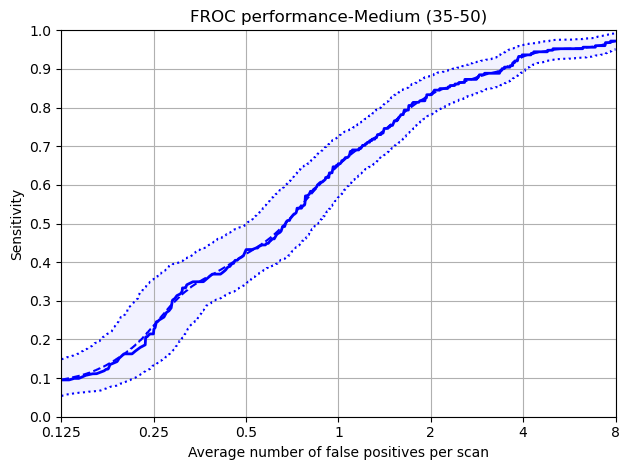

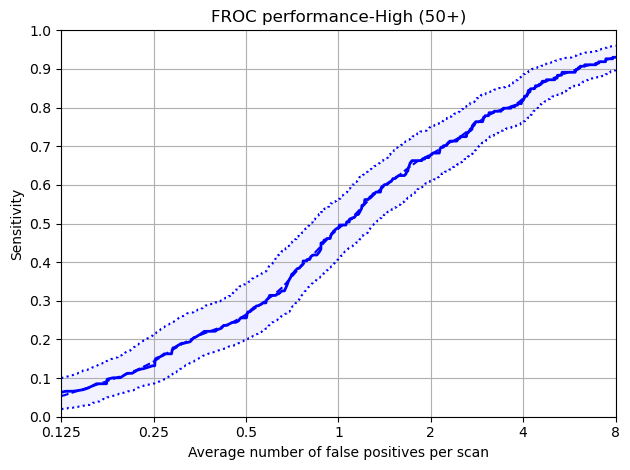

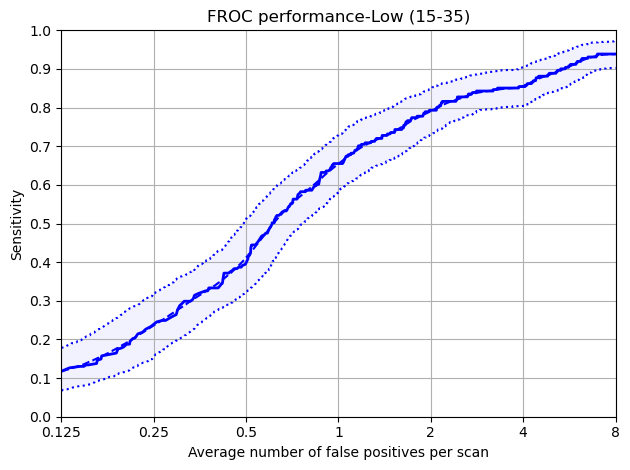

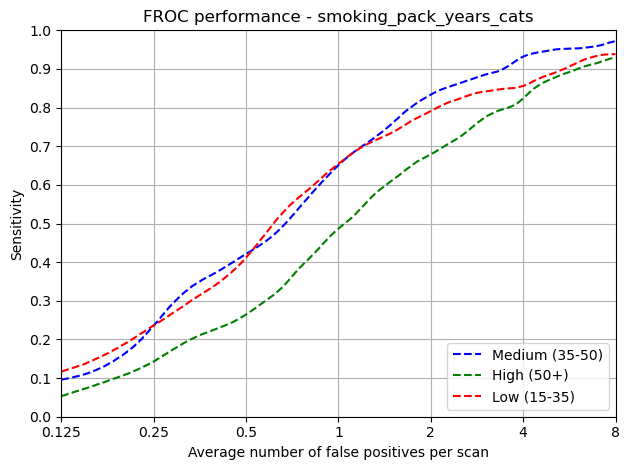

In [11]:
protected_group = 'smoking_pack_years_cats'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable Vs Non-Actionable

Protected Group: Non-Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpx78yobe0/annotations.csv
Total number of included nodule annotations: 476
Total number of nodule annotations: 476
Cases: 813
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:48<00:00, 20.50it/s]


0                  159                476   \
0  0.12 (0.08 - 0.16)  0.26 (0.2 - 0.33)  0.43 (0.36 - 0.5)   

                 1111                2381                4920  \
0  0.68 (0.62 - 0.73)  0.82 (0.79 - 0.87)  0.92 (0.89 - 0.95)   

                 9999  
0  0.96 (0.94 - 0.98)

fps  mean_sens  low_sens  high_sens
0     0.12       0.12      0.08       0.16
159   0.25       0.26      0.20       0.33
476   0.50       0.43      0.36       0.50
1111  1.00       0.68      0.62       0.73
2381  2.00       0.82      0.79       0.87
4920  4.00       0.92      0.89       0.95
9999  8.00       0.96      0.94       0.98

Mean Sensitivity: 0.6 Low Sensitivity: 0.55 High Sensitivity: 0.65


True positives        475
0                                    False positives  37502.000
1                                    False negatives      1.000
2                                     True negatives      0.000
3                         Total number of candidates  38448.000
4                            Total number of nodules    476.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    475.000
7                                        Sensitivity      0.998
8              Average number of candidates per scan     47.292

Protected Group: Actonable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp4pdcqr39/annotations.csv
Total number of included nodule annotations: 295
Total number of nodule annotations: 295
Cases: 359


100%|██████████| 1000/1000 [00:22<00:00, 44.14it/s]


0                   159                476   \
0  0.04 (0.01 - 0.08)  0.11 (0.06 - 0.16)  0.26 (0.2 - 0.33)   

                 1111                2381                4920  \
0  0.45 (0.38 - 0.53)  0.66 (0.59 - 0.73)  0.79 (0.75 - 0.85)   

                 9999  
0  0.89 (0.85 - 0.93)

fps  mean_sens  low_sens  high_sens
0     0.12       0.04      0.01       0.08
159   0.25       0.11      0.06       0.16
476   0.50       0.26      0.20       0.33
1111  1.00       0.45      0.38       0.53
2381  2.00       0.66      0.59       0.73
4920  4.00       0.79      0.75       0.85
9999  8.00       0.89      0.85       0.93

Mean Sensitivity: 0.46 Low Sensitivity: 0.41 High Sensitivity: 0.52


True positives        287
0                                    False positives  22135.000
1                                    False negatives      8.000
2                                     True negatives      0.000
3                         Total number of candidates  22659.000
4                            Total number of nodules    295.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    237.000
7                                        Sensitivity      0.973
8              Average number of candidates per scan     63.117

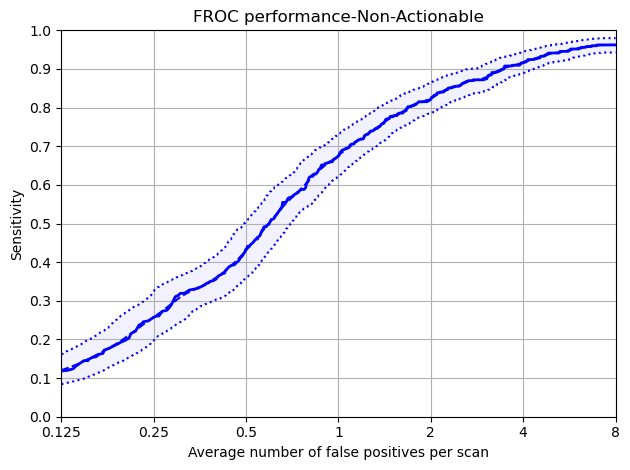

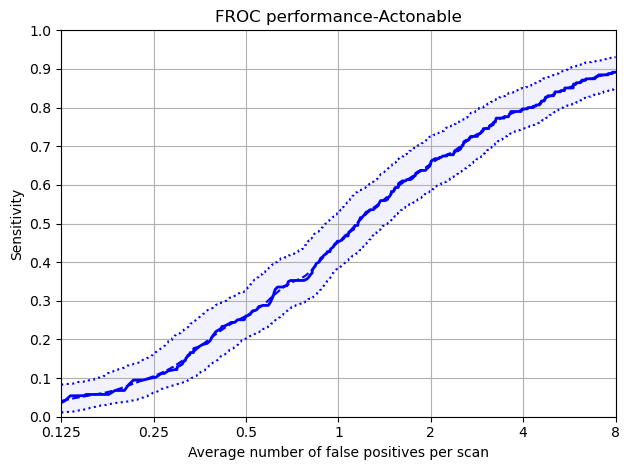

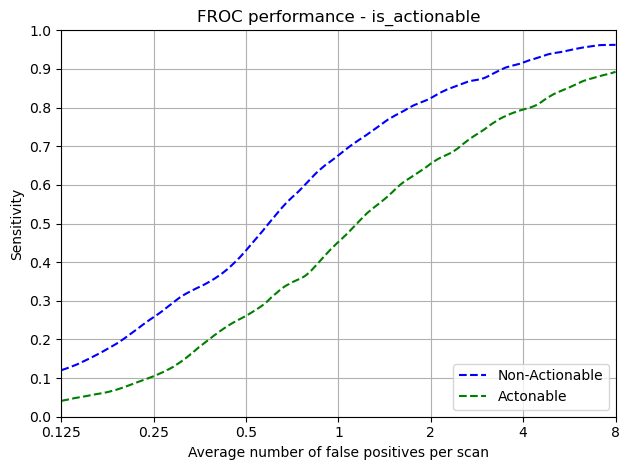

In [12]:
protected_group = 'is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable Gender

Protected Group: Male_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpim55txtz/annotations.csv
Total number of included nodule annotations: 184
Total number of nodule annotations: 184
Cases: 201


100%|██████████| 1000/1000 [00:12<00:00, 78.71it/s]


0                   159                 476   \
0  0.06 (0.02 - 0.11)  0.11 (0.05 - 0.19)  0.24 (0.16 - 0.33)   

                1111                2381                4920  \
0  0.41 (0.31 - 0.5)  0.62 (0.52 - 0.71)  0.78 (0.71 - 0.85)   

                9999  
0  0.9 (0.84 - 0.96)

fps  mean_sens  low_sens  high_sens
0     0.12       0.06      0.02       0.11
159   0.25       0.11      0.05       0.19
476   0.50       0.24      0.16       0.33
1111  1.00       0.41      0.31       0.50
2381  2.00       0.62      0.52       0.71
4920  4.00       0.78      0.71       0.85
9999  8.00       0.90      0.84       0.96

Mean Sensitivity: 0.45 Low Sensitivity: 0.37 High Sensitivity: 0.52


True positives        177
0                                    False positives  13089.000
1                                    False negatives      7.000
2                                     True negatives      0.000
3                         Total number of candidates  13409.000
4                            Total number of nodules    184.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    143.000
7                                        Sensitivity      0.962
8              Average number of candidates per scan     66.711

Protected Group: Female_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp1ufh1pw4/annotations.csv
Total number of included nodule annotations: 111
Total number of nodule annotations: 111
Cases: 159


100%|██████████| 1000/1000 [00:08<00:00, 114.70it/s]


0                   159               476   \
0  0.02 (0.0 - 0.07)  0.12 (0.03 - 0.25)  0.3 (0.2 - 0.43)   

                 1111               2381               4920  \
0  0.55 (0.45 - 0.64)  0.69 (0.6 - 0.79)  0.83 (0.75 - 0.9)   

                 9999  
0  0.88 (0.81 - 0.94)

fps  mean_sens  low_sens  high_sens
0     0.12       0.02      0.00       0.07
159   0.25       0.12      0.03       0.25
476   0.50       0.30      0.20       0.43
1111  1.00       0.55      0.45       0.64
2381  2.00       0.69      0.60       0.79
4920  4.00       0.83      0.75       0.90
9999  8.00       0.88      0.81       0.94

Mean Sensitivity: 0.48 Low Sensitivity: 0.41 High Sensitivity: 0.57


True positives       110
0                                    False positives  9046.000
1                                    False negatives     1.000
2                                     True negatives     0.000
3                         Total number of candidates  9250.000
4                            Total number of nodules   111.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    94.000
7                                        Sensitivity     0.991
8              Average number of candidates per scan    58.176

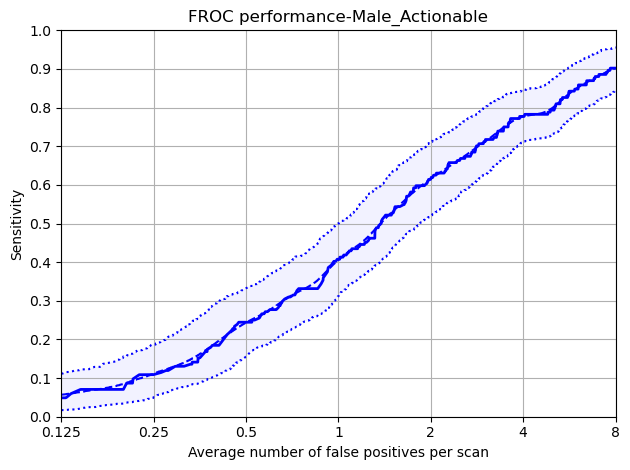

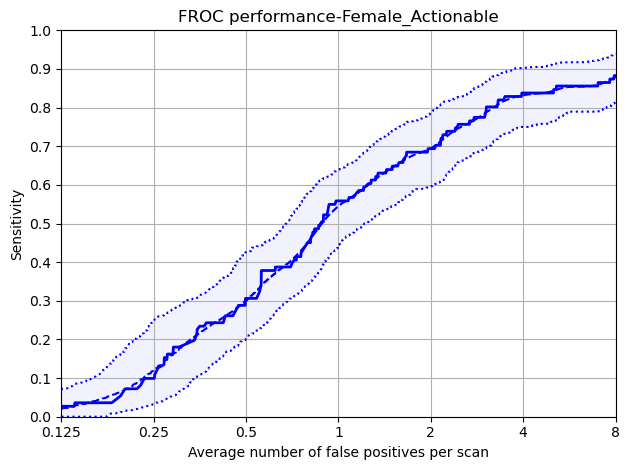

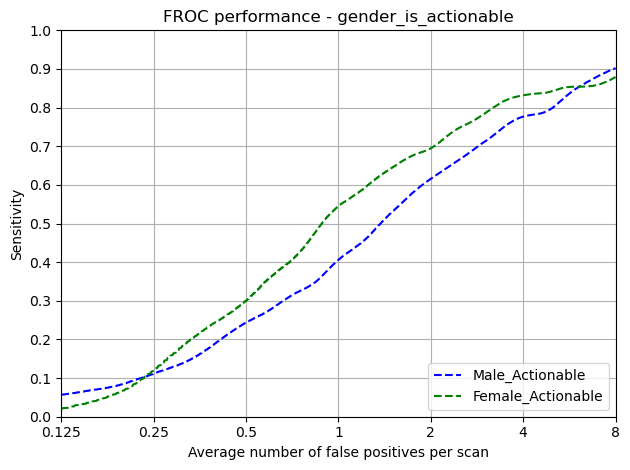

In [13]:
protected_group = 'gender_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)


### Non-Actionable Gender

Protected Group: Female_Non_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpjt8_qwbo/annotations.csv
Total number of included nodule annotations: 186
Total number of nodule annotations: 186
Cases: 321
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:14<00:00, 71.00it/s]


0                   159                 476   \
0  0.09 (0.03 - 0.21)  0.25 (0.14 - 0.35)  0.48 (0.33 - 0.61)   

                1111                2381                4920  \
0  0.7 (0.62 - 0.79)  0.85 (0.78 - 0.91)  0.92 (0.88 - 0.95)   

                 9999  
0  0.97 (0.94 - 0.99)

fps  mean_sens  low_sens  high_sens
0     0.12       0.09      0.03       0.21
159   0.25       0.25      0.14       0.35
476   0.50       0.48      0.33       0.61
1111  1.00       0.70      0.62       0.79
2381  2.00       0.85      0.78       0.91
4920  4.00       0.92      0.88       0.95
9999  8.00       0.97      0.94       0.99

Mean Sensitivity: 0.61 Low Sensitivity: 0.53 High Sensitivity: 0.69


True positives        185
0                                    False positives  13365.000
1                                    False negatives      1.000
2                                     True negatives      0.000
3                         Total number of candidates  13744.000
4                            Total number of nodules    186.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    198.000
7                                        Sensitivity      0.995
8              Average number of candidates per scan     42.816

Protected Group: Male_Non_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpm9qgoc88/annotations.csv
Total number of included nodule annotations: 290
Total number of nodule annotations: 290
Cases: 493


100%|██████████| 1000/1000 [00:27<00:00, 36.47it/s]


0                   159                 476   \
0  0.15 (0.1 - 0.2)  0.27 (0.19 - 0.35)  0.42 (0.35 - 0.51)   

                 1111                2381                4920  \
0  0.66 (0.59 - 0.73)  0.83 (0.77 - 0.87)  0.91 (0.87 - 0.94)   

                 9999  
0  0.96 (0.94 - 0.99)

fps  mean_sens  low_sens  high_sens
0     0.12       0.15      0.10       0.20
159   0.25       0.27      0.19       0.35
476   0.50       0.42      0.35       0.51
1111  1.00       0.66      0.59       0.73
2381  2.00       0.83      0.77       0.87
4920  4.00       0.91      0.87       0.94
9999  8.00       0.96      0.94       0.99

Mean Sensitivity: 0.6 Low Sensitivity: 0.54 High Sensitivity: 0.66


True positives       290
0                                    False positives  24137.00
1                                    False negatives      0.00
2                                     True negatives      0.00
3                         Total number of candidates  24704.00
4                            Total number of nodules    290.00
5             Ignored candidates on excluded nodules      0.00
6      Ignored candidates which were double detec...    277.00
7                                        Sensitivity      1.00
8              Average number of candidates per scan     50.11

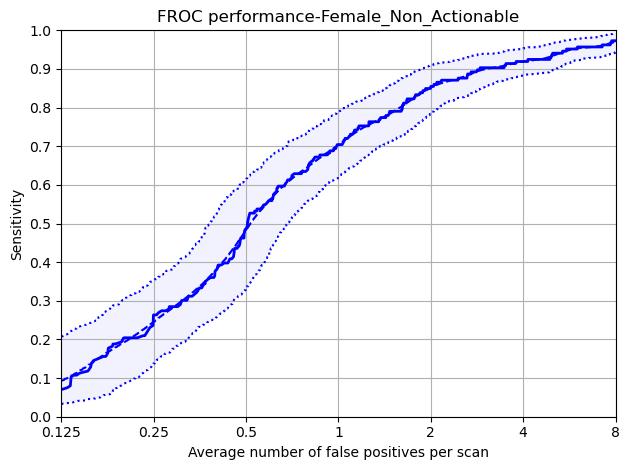

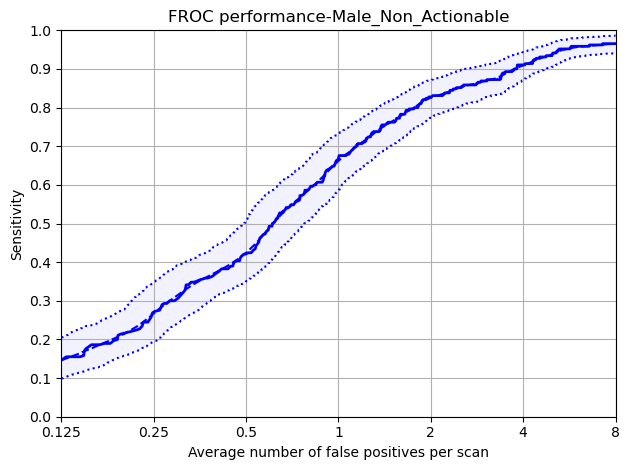

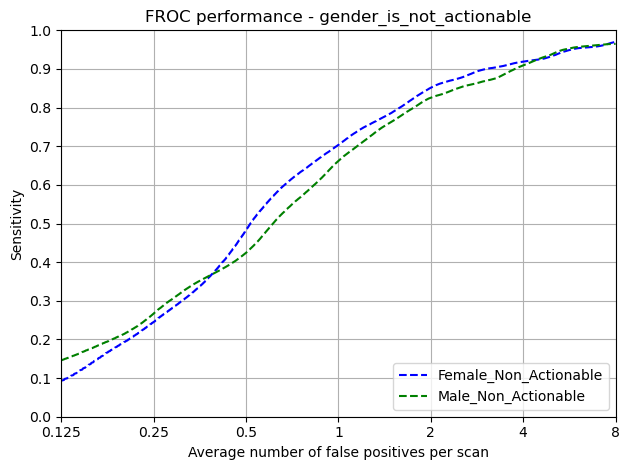

In [14]:
protected_group = 'gender_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable Ethnic Group

Protected Group: White_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpr0a2qy5r/annotations.csv
Total number of included nodule annotations: 229
Total number of nodule annotations: 229
Cases: 281


100%|██████████| 1000/1000 [00:19<00:00, 51.64it/s]


0                  159                 476   \
0  0.03 (0.01 - 0.07)  0.1 (0.05 - 0.16)  0.28 (0.21 - 0.36)   

                 1111                2381               4920  \
0  0.48 (0.41 - 0.56)  0.64 (0.56 - 0.71)  0.8 (0.74 - 0.86)   

                 9999  
0  0.89 (0.84 - 0.93)

fps  mean_sens  low_sens  high_sens
0     0.12       0.03      0.01       0.07
159   0.25       0.10      0.05       0.16
476   0.50       0.28      0.21       0.36
1111  1.00       0.48      0.41       0.56
2381  2.00       0.64      0.56       0.71
4920  4.00       0.80      0.74       0.86
9999  8.00       0.89      0.84       0.93

Mean Sensitivity: 0.46 Low Sensitivity: 0.4 High Sensitivity: 0.52


True positives        225
0                                    False positives  17782.000
1                                    False negatives      4.000
2                                     True negatives      0.000
3                         Total number of candidates  18201.000
4                            Total number of nodules    229.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    194.000
7                                        Sensitivity      0.983
8              Average number of candidates per scan     64.772

Protected Group: Asian_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp3ihgc25o/annotations.csv
Total number of included nodule annotations: 31
Total number of nodule annotations: 31
Cases: 39


100%|██████████| 1000/1000 [00:02<00:00, 393.97it/s]


0                 159                476                1111  \
0  0.13 (0.0 - 0.43)  0.16 (0.0 - 0.5)  0.21 (0.0 - 0.57)  0.37 (0.14 - 0.7)   

                2381              4920              9999  
0  0.57 (0.28 - 0.9)  0.7 (0.33 - 1.0)  0.82 (0.5 - 1.0)

fps  mean_sens  low_sens  high_sens
0     0.12       0.13      0.00       0.43
159   0.25       0.16      0.00       0.50
476   0.50       0.21      0.00       0.57
1111  1.00       0.37      0.14       0.70
2381  2.00       0.57      0.28       0.90
4920  4.00       0.70      0.33       1.00
9999  8.00       0.82      0.50       1.00

Mean Sensitivity: 0.42 Low Sensitivity: 0.18 High Sensitivity: 0.73


True positives        28
0                                    False positives  2243.000
1                                    False negatives     3.000
2                                     True negatives     0.000
3                         Total number of candidates  2281.000
4                            Total number of nodules    31.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    10.000
7                                        Sensitivity     0.903
8              Average number of candidates per scan    58.487

Protected Group: Black_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpeskil91m/annotations.csv
Total number of included nodule annotations: 25
Total number of nodule annotations: 25
Cases: 21


100%|██████████| 1000/1000 [00:01<00:00, 655.83it/s]


0                  159                476               1111  \
0  0.07 (0.0 - 0.29)  0.14 (0.0 - 0.43)  0.22 (0.0 - 0.78)  0.6 (0.16 - 0.9)   

                 2381               4920              9999  
0  0.76 (0.55 - 0.94)  0.87 (0.67 - 1.0)  0.97 (0.9 - 1.0)

fps  mean_sens  low_sens  high_sens
0     0.12       0.07      0.00       0.29
159   0.25       0.14      0.00       0.43
476   0.50       0.22      0.00       0.78
1111  1.00       0.60      0.16       0.90
2381  2.00       0.76      0.55       0.94
4920  4.00       0.87      0.67       1.00
9999  8.00       0.97      0.90       1.00

Mean Sensitivity: 0.52 Low Sensitivity: 0.33 High Sensitivity: 0.76


True positives        24
0                                    False positives  1036.000
1                                    False negatives     1.000
2                                     True negatives     0.000
3                         Total number of candidates  1081.000
4                            Total number of nodules    25.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    21.000
7                                        Sensitivity     0.960
8              Average number of candidates per scan    51.476

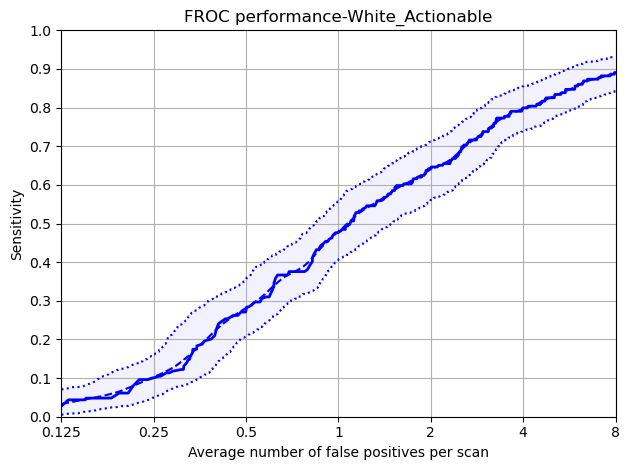

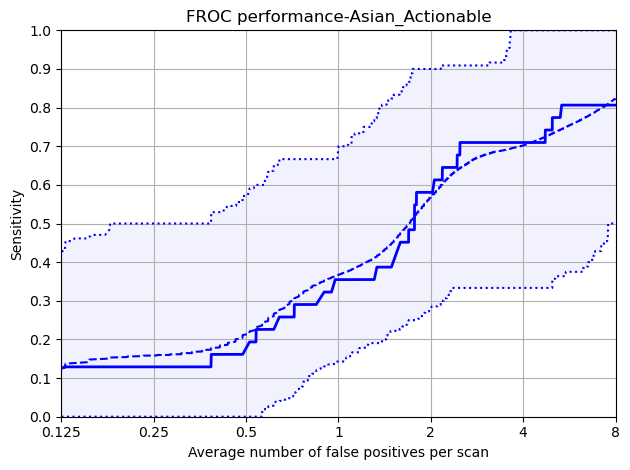

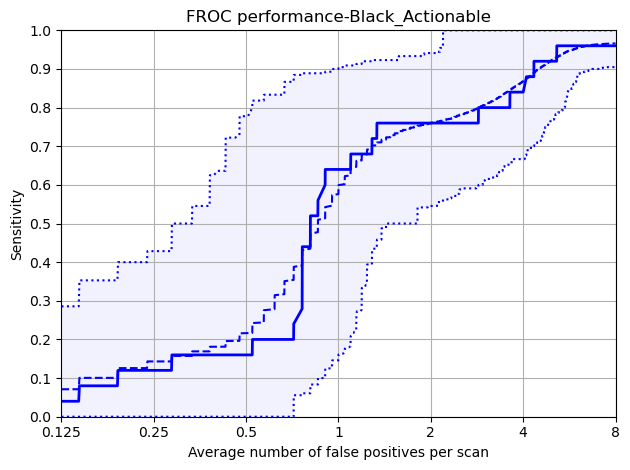

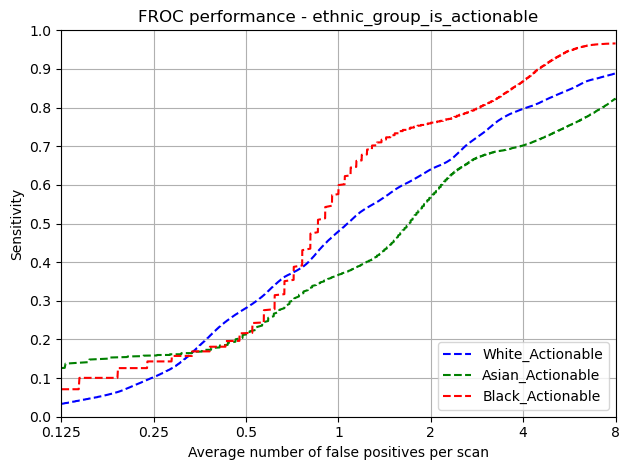

In [15]:
protected_group = 'ethnic_group_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)


### NonActionable - Ethnic Group

Protected Group: White_Non_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpq5o5hslk/annotations.csv
Total number of included nodule annotations: 367
Total number of nodule annotations: 367
Cases: 590
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:35<00:00, 27.95it/s]


0                   159                476   \
0  0.11 (0.07 - 0.15)  0.24 (0.17 - 0.32)  0.41 (0.34 - 0.5)   

                 1111                2381                4920  \
0  0.66 (0.59 - 0.72)  0.81 (0.76 - 0.86)  0.92 (0.89 - 0.95)   

                 9999  
0  0.97 (0.95 - 0.99)

fps  mean_sens  low_sens  high_sens
0     0.12       0.11      0.07       0.15
159   0.25       0.24      0.17       0.32
476   0.50       0.41      0.34       0.50
1111  1.00       0.66      0.59       0.72
2381  2.00       0.81      0.76       0.86
4920  4.00       0.92      0.89       0.95
9999  8.00       0.97      0.95       0.99

Mean Sensitivity: 0.59 Low Sensitivity: 0.54 High Sensitivity: 0.64


True positives        366
0                                    False positives  29035.000
1                                    False negatives      1.000
2                                     True negatives      0.000
3                         Total number of candidates  29752.000
4                            Total number of nodules    367.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    355.000
7                                        Sensitivity      0.997
8              Average number of candidates per scan     50.427

Protected Group: Black_Non_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp1_279_df/annotations.csv
Total number of included nodule annotations: 37
Total number of nodule annotations: 37
Cases: 81


100%|██████████| 1000/1000 [00:03<00:00, 301.06it/s]


0                  159                 476   \
0  0.25 (0.13 - 0.42)  0.35 (0.18 - 0.5)  0.53 (0.37 - 0.72)   

                1111                2381               4920               9999  
0  0.8 (0.66 - 0.92)  0.81 (0.69 - 0.93)  0.91 (0.77 - 1.0)  0.92 (0.79 - 1.0)

fps  mean_sens  low_sens  high_sens
0     0.12       0.25      0.13       0.42
159   0.25       0.35      0.18       0.50
476   0.50       0.53      0.37       0.72
1111  1.00       0.80      0.66       0.92
2381  2.00       0.81      0.69       0.93
4920  4.00       0.91      0.77       1.00
9999  8.00       0.92      0.79       1.00

Mean Sensitivity: 0.65 Low Sensitivity: 0.51 High Sensitivity: 0.78


True positives        37
0                                    False positives  2914.000
1                                    False negatives     0.000
2                                     True negatives     0.000
3                         Total number of candidates  2991.000
4                            Total number of nodules    37.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    40.000
7                                        Sensitivity     1.000
8              Average number of candidates per scan    36.926

Protected Group: Asian_Non_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp4c41cfd9/annotations.csv
Total number of included nodule annotations: 51
Total number of nodule annotations: 51
Cases: 97


100%|██████████| 1000/1000 [00:04<00:00, 244.65it/s]


0                   159                476                1111  \
0  0.05 (0.0 - 0.2)  0.19 (0.05 - 0.38)  0.4 (0.22 - 0.61)  0.7 (0.57 - 0.81)   

                 2381                4920               9999  
0  0.84 (0.72 - 0.94)  0.92 (0.84 - 0.98)  0.94 (0.88 - 1.0)

fps  mean_sens  low_sens  high_sens
0     0.12       0.05      0.00       0.20
159   0.25       0.19      0.05       0.38
476   0.50       0.40      0.22       0.61
1111  1.00       0.70      0.57       0.81
2381  2.00       0.84      0.72       0.94
4920  4.00       0.92      0.84       0.98
9999  8.00       0.94      0.88       1.00

Mean Sensitivity: 0.58 Low Sensitivity: 0.47 High Sensitivity: 0.7


True positives       51
0                                    False positives  3674.00
1                                    False negatives     0.00
2                                     True negatives     0.00
3                         Total number of candidates  3784.00
4                            Total number of nodules    51.00
5             Ignored candidates on excluded nodules     0.00
6      Ignored candidates which were double detec...    59.00
7                                        Sensitivity     1.00
8              Average number of candidates per scan    39.01

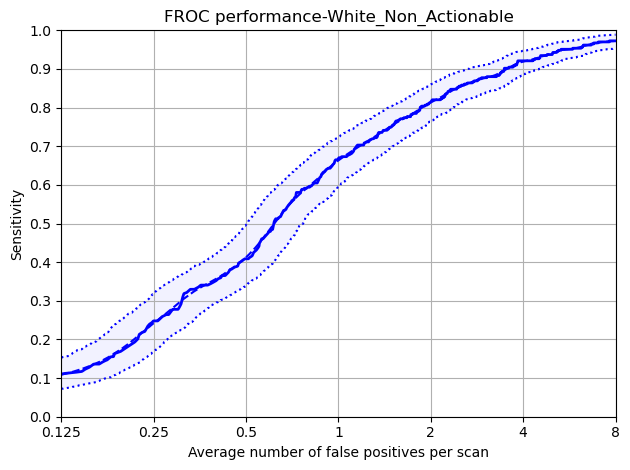

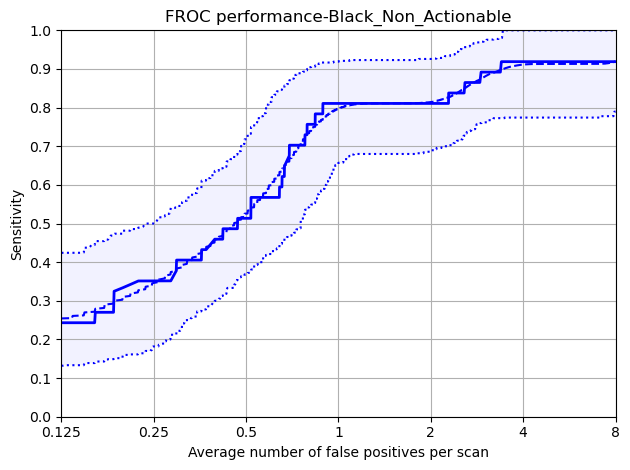

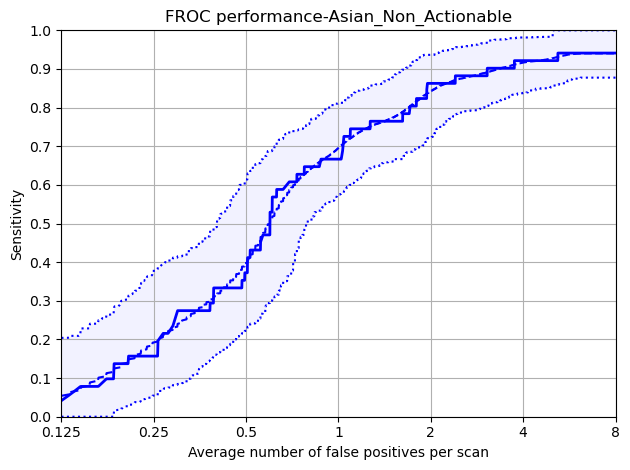

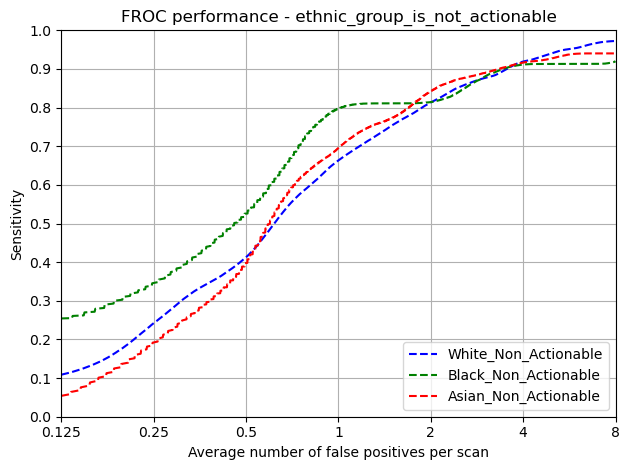

In [16]:
protected_group = 'ethnic_group_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable IMDRank

Protected Group: Medium_IMDRank_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpwrypa206/annotations.csv
Total number of included nodule annotations: 112
Total number of nodule annotations: 112
Cases: 127


100%|██████████| 1000/1000 [00:08<00:00, 123.18it/s]


0                   159                 476   \
0  0.05 (0.0 - 0.13)  0.12 (0.04 - 0.26)  0.29 (0.18 - 0.43)   

                 1111                2381                4920  \
0  0.46 (0.35 - 0.57)  0.67 (0.55 - 0.77)  0.78 (0.69 - 0.88)   

                 9999  
0  0.89 (0.81 - 0.96)

fps  mean_sens  low_sens  high_sens
0     0.12       0.05      0.00       0.13
159   0.25       0.12      0.04       0.26
476   0.50       0.29      0.18       0.43
1111  1.00       0.46      0.35       0.57
2381  2.00       0.67      0.55       0.77
4920  4.00       0.78      0.69       0.88
9999  8.00       0.89      0.81       0.96

Mean Sensitivity: 0.47 Low Sensitivity: 0.37 High Sensitivity: 0.57


True positives       109
0                                    False positives  7743.000
1                                    False negatives     3.000
2                                     True negatives     0.000
3                         Total number of candidates  7936.000
4                            Total number of nodules   112.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    84.000
7                                        Sensitivity     0.973
8              Average number of candidates per scan    62.488

Protected Group: Low_IMDRank_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpa3tcreqc/annotations.csv
Total number of included nodule annotations: 90
Total number of nodule annotations: 90
Cases: 119


100%|██████████| 1000/1000 [00:08<00:00, 121.76it/s]


0                   159                476   \
0  0.02 (0.0 - 0.07)  0.06 (0.01 - 0.18)  0.2 (0.11 - 0.31)   

                 1111                2381               4920  \
0  0.42 (0.28 - 0.58)  0.65 (0.55 - 0.76)  0.78 (0.7 - 0.88)   

                 9999  
0  0.89 (0.81 - 0.97)

fps  mean_sens  low_sens  high_sens
0     0.12       0.02      0.00       0.07
159   0.25       0.06      0.01       0.18
476   0.50       0.20      0.11       0.31
1111  1.00       0.42      0.28       0.58
2381  2.00       0.65      0.55       0.76
4920  4.00       0.78      0.70       0.88
9999  8.00       0.89      0.81       0.97

Mean Sensitivity: 0.43 Low Sensitivity: 0.35 High Sensitivity: 0.54


True positives        87
0                                    False positives  7590.000
1                                    False negatives     3.000
2                                     True negatives     0.000
3                         Total number of candidates  7753.000
4                            Total number of nodules    90.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    76.000
7                                        Sensitivity     0.967
8              Average number of candidates per scan    65.151

Protected Group: High_IMDRank_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpe4zbotcy/annotations.csv
Total number of included nodule annotations: 93
Total number of nodule annotations: 93
Cases: 115


100%|██████████| 1000/1000 [00:07<00:00, 140.55it/s]


0                   159                 476   \
0  0.06 (0.01 - 0.15)  0.14 (0.05 - 0.28)  0.31 (0.17 - 0.44)   

                 1111               2381                4920  \
0  0.49 (0.35 - 0.63)  0.65 (0.5 - 0.79)  0.83 (0.74 - 0.91)   

                 9999  
0  0.91 (0.84 - 0.97)

fps  mean_sens  low_sens  high_sens
0     0.12       0.06      0.01       0.15
159   0.25       0.14      0.05       0.28
476   0.50       0.31      0.17       0.44
1111  1.00       0.49      0.35       0.63
2381  2.00       0.65      0.50       0.79
4920  4.00       0.83      0.74       0.91
9999  8.00       0.91      0.84       0.97

Mean Sensitivity: 0.48 Low Sensitivity: 0.38 High Sensitivity: 0.6


True positives        91
0                                    False positives  6802.000
1                                    False negatives     2.000
2                                     True negatives     0.000
3                         Total number of candidates  6970.000
4                            Total number of nodules    93.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    77.000
7                                        Sensitivity     0.978
8              Average number of candidates per scan    60.609

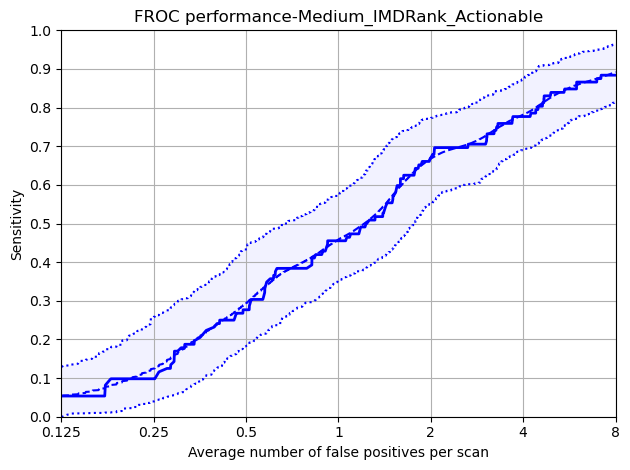

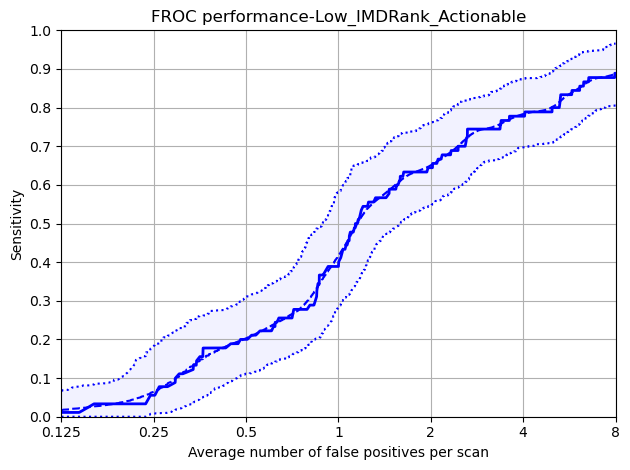

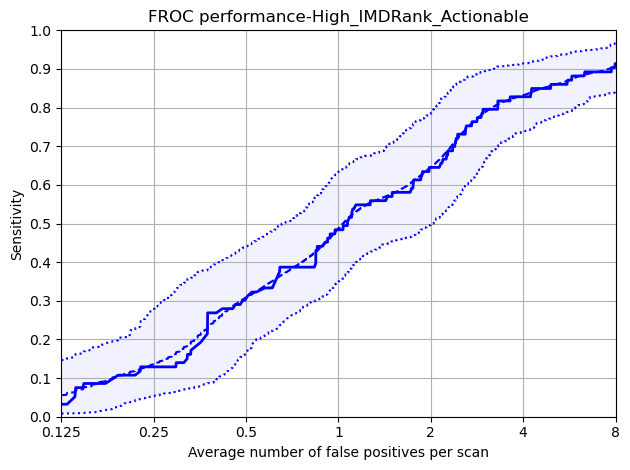

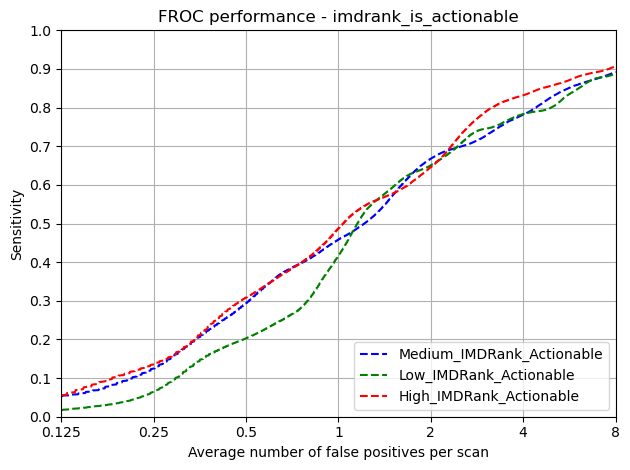

In [17]:
protected_group = 'imdrank_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)

### Actionable Smoking Status

Protected Group: Medium_Pack_Years_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp1f8aetad/annotations.csv
Total number of included nodule annotations: 80
Total number of nodule annotations: 80
Cases: 120


100%|██████████| 1000/1000 [00:07<00:00, 133.85it/s]


0                   159               476               1111  \
0  0.12 (0.03 - 0.25)  0.31 (0.07 - 0.51)  0.5 (0.39 - 0.6)  0.7 (0.6 - 0.81)   

                 2381                4920               9999  
0  0.86 (0.78 - 0.94)  0.92 (0.86 - 0.97)  0.96 (0.92 - 1.0)

fps  mean_sens  low_sens  high_sens
0     0.12       0.12      0.03       0.25
159   0.25       0.31      0.07       0.51
476   0.50       0.50      0.39       0.60
1111  1.00       0.70      0.60       0.81
2381  2.00       0.86      0.78       0.94
4920  4.00       0.92      0.86       0.97
9999  8.00       0.96      0.92       1.00

Mean Sensitivity: 0.62 Low Sensitivity: 0.52 High Sensitivity: 0.73


True positives        80
0                                    False positives  6840.000
1                                    False negatives     0.000
2                                     True negatives     0.000
3                         Total number of candidates  7000.000
4                            Total number of nodules    80.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    80.000
7                                        Sensitivity     1.000
8              Average number of candidates per scan    58.333

Protected Group: High_Pack_Years_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpokkq2uic/annotations.csv
Total number of included nodule annotations: 113
Total number of nodule annotations: 113
Cases: 126


100%|██████████| 1000/1000 [00:08<00:00, 124.24it/s]


0                   159                 476   \
0  0.03 (0.0 - 0.07)  0.06 (0.01 - 0.13)  0.13 (0.07 - 0.22)   

                 1111              2381               4920                9999  
0  0.28 (0.18 - 0.38)  0.5 (0.4 - 0.62)  0.71 (0.62 - 0.8)  0.89 (0.83 - 0.95)

fps  mean_sens  low_sens  high_sens
0     0.12       0.03      0.00       0.07
159   0.25       0.06      0.01       0.13
476   0.50       0.13      0.07       0.22
1111  1.00       0.28      0.18       0.38
2381  2.00       0.50      0.40       0.62
4920  4.00       0.71      0.62       0.80
9999  8.00       0.89      0.83       0.95

Mean Sensitivity: 0.37 Low Sensitivity: 0.3 High Sensitivity: 0.45


True positives       109
0                                    False positives  7987.000
1                                    False negatives     4.000
2                                     True negatives     0.000
3                         Total number of candidates  8166.000
4                            Total number of nodules   113.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    70.000
7                                        Sensitivity     0.965
8              Average number of candidates per scan    64.810

Protected Group: Low_Pack_Years_Actionable


PERIFISSURAL
nodule_type         100.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp078sk41k/annotations.csv
Total number of included nodule annotations: 102
Total number of nodule annotations: 102
Cases: 115


100%|██████████| 1000/1000 [00:07<00:00, 133.19it/s]


0                   159                 476   \
0  0.03 (0.0 - 0.1)  0.11 (0.03 - 0.21)  0.25 (0.17 - 0.34)   

                 1111                2381                4920  \
0  0.46 (0.36 - 0.57)  0.62 (0.51 - 0.72)  0.77 (0.67 - 0.85)   

                 9999  
0  0.84 (0.74 - 0.93)

fps  mean_sens  low_sens  high_sens
0     0.12       0.03      0.00       0.10
159   0.25       0.11      0.03       0.21
476   0.50       0.25      0.17       0.34
1111  1.00       0.46      0.36       0.57
2381  2.00       0.62      0.51       0.72
4920  4.00       0.77      0.67       0.85
9999  8.00       0.84      0.74       0.93

Mean Sensitivity: 0.44 Low Sensitivity: 0.35 High Sensitivity: 0.53


True positives        98
0                                    False positives  7308.000
1                                    False negatives     4.000
2                                     True negatives     0.000
3                         Total number of candidates  7493.000
4                            Total number of nodules   102.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    87.000
7                                        Sensitivity     0.961
8              Average number of candidates per scan    65.157

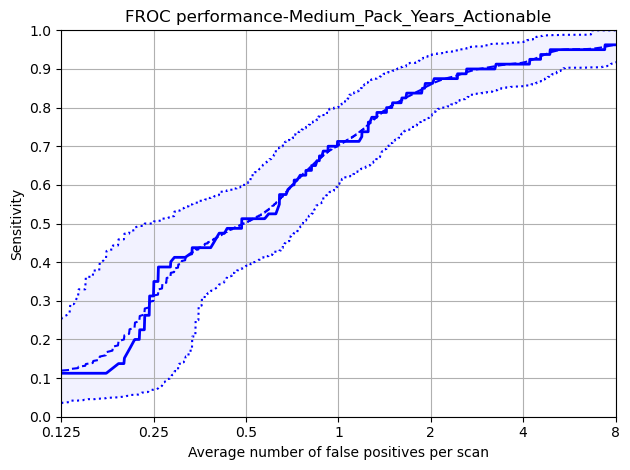

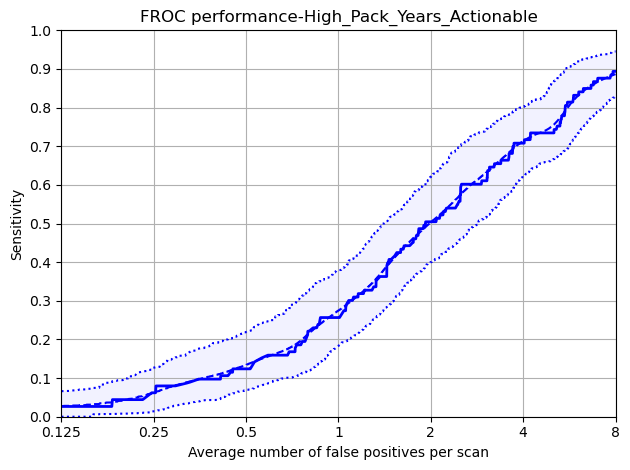

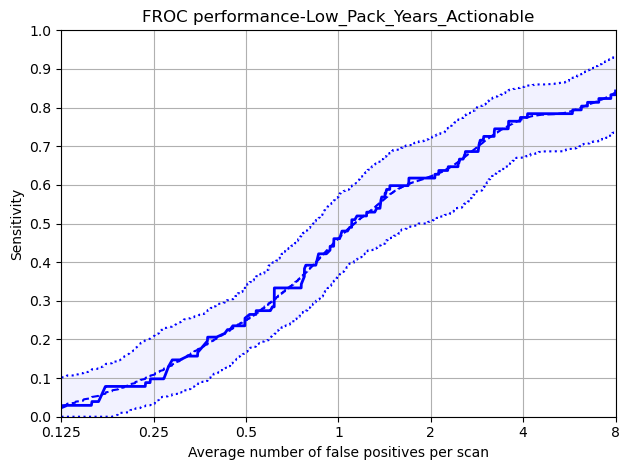

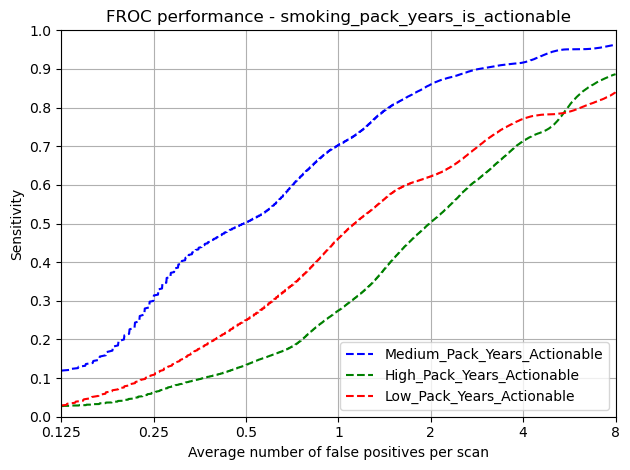

In [18]:
protected_group = 'smoking_pack_years_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/perifissural_only/{protected_group}'
)


### False Positive and Miss Analysis


In [20]:
thresholds = get_thresholds(detection_summit_summit)
print(thresholds)
missed_metadata = miss_anaysis_at_fpps(
    model='detection',
    scans_metadata=scan_metadata,
    scans_path=f'{workspace_path}/metadata/summit/perifissural_only/test_scans.csv',
    annotations_path=f'{workspace_path}/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/annotations_excluded_empty.csv',
    predictions_path=detection_predictions_path,
    thresholds=thresholds
)

[0.97802734375, 0.9658203125, 0.94580078125, 0.90771484375, 0.83349609375, 0.66552734375, 0.3583984375]
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv
Total number of included nodule annotations: 788
Total number of nodule annotations: 788
Cases: 1189
Missed Annotations at 0.97802734375 FPPs: 726
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv
Total number of included nodule annotations: 788
Total number of nodule annotations: 788
Cases: 1189
Missed Annotations at 0.9658203125 FPPs: 636
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv
Total number of included nodule annotations: 788
Total number of nodule annotations: 788
Cases: 1189
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: sum

In [22]:
hit_and_miss_dict = get_protected_group_by_nodule_type(missed_metadata)

#### Incremental FROC Scores - Gender/ Ethnic Group / Nodule Type

In [23]:

# display(hit_and_miss_dict[0])
recode_dict = {}
for idx in range(7):
    hmm = {}
    for slice in ['all','actionable']:
        for protected_group in ['MALE','FEMALE','All', 'Asian or Asian British', 'Black', 'White']:
            for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:
            
                try:

                    group = 'gender' if protected_group in ['MALE','FEMALE','All'] else 'ethnic_group'

                    total = hit_and_miss_dict[idx][slice][group][(True,type)][protected_group] + hit_and_miss_dict[idx][slice][group][(False,type)][protected_group]
                    hits = hit_and_miss_dict[idx][slice][group][(False,type)][protected_group]
                    perc_hits = round(100 * (hits/total),0)

                    hmm[f'{slice}_{protected_group}_{type}_Hits%'] = perc_hits
                except:
                    print(f'Error: {idx}, {slice}, {protected_group}, {type}')
                    hmm[f'{slice}_{protected_group}_{type}_Hits%'] = 100
                    

    recode_dict[idx] = hmm

pd.DataFrame.from_dict(recode_dict, orient='index').head(7)

df = pd.DataFrame.from_dict(recode_dict, orient='index').head(7)

# Remove ".0" from each value in the dataframe
df = df.applymap(lambda x: str(x).replace('.0', ''))

# Collapse each column into comma-delimited values
collapsed_df = df.apply(lambda x: ', '.join(x), axis=0)

display(collapsed_df)

from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def calculate_significant_differences(df, group1_name, group2_name):

    group1 = df[group1_name].astype(int).values
    group2 = df[group2_name].astype(int).values

    shapiro_group1 = shapiro(group1)
    shapiro_group2 = shapiro(group2)

    print('*'*50)
    if shapiro_group1[1] > 0.05 and shapiro_group2[1] > 0.05:
        t_test = ttest_ind(group1, group2)
        print(f'Independent T-Test: {round(t_test.statistic,3)}, {round(t_test.pvalue,3)}')
    else:
        manwhitney = mannwhitneyu(group1, group2)
        print(f'Mann-Whitney U Test: {round(manwhitney.statistic,3)}, {round(manwhitney.pvalue,3)}')

a='White'
b='Black'

for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:

    print(f'*** all {type} ***')
    group1 = f'all_{a}_{type}_Hits%'
    group2 = f'all_{b}_{type}_Hits%'
    calculate_significant_differences(df, group1, group2)

for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:

    print(f'*** actionable {type} ***')
    group1 = f'actionable_{a}_{type}_Hits%'
    group2 = f'actionable_{b}_{type}_Hits%'
    calculate_significant_differences(df, group1, group2)

Error: 0, all, MALE, SOLID
Error: 0, all, MALE, NON_SOLID
Error: 0, all, MALE, PART_SOLID
Error: 0, all, MALE, CALCIFIED
Error: 0, all, FEMALE, SOLID
Error: 0, all, FEMALE, NON_SOLID
Error: 0, all, FEMALE, PART_SOLID
Error: 0, all, FEMALE, CALCIFIED
Error: 0, all, All, SOLID
Error: 0, all, All, NON_SOLID
Error: 0, all, All, PART_SOLID
Error: 0, all, All, CALCIFIED
Error: 0, all, Asian or Asian British, SOLID
Error: 0, all, Asian or Asian British, NON_SOLID
Error: 0, all, Asian or Asian British, PART_SOLID
Error: 0, all, Asian or Asian British, CALCIFIED
Error: 0, all, Black, SOLID
Error: 0, all, Black, NON_SOLID
Error: 0, all, Black, PART_SOLID
Error: 0, all, Black, CALCIFIED
Error: 0, all, White, SOLID
Error: 0, all, White, NON_SOLID
Error: 0, all, White, PART_SOLID
Error: 0, all, White, CALCIFIED
Error: 0, actionable, MALE, SOLID
Error: 0, actionable, MALE, NON_SOLID
Error: 0, actionable, MALE, PART_SOLID
Error: 0, actionable, MALE, CALCIFIED
Error: 0, actionable, FEMALE, SOLID
Error

all_MALE_SOLID_Hits%                                    100, 100, 100, 100, 100, 100, 100
all_MALE_NON_SOLID_Hits%                                100, 100, 100, 100, 100, 100, 100
all_MALE_PART_SOLID_Hits%                               100, 100, 100, 100, 100, 100, 100
all_MALE_PERIFISSURAL_Hits%                                    10, 21, 37, 60, 77, 87, 95
all_MALE_CALCIFIED_Hits%                                100, 100, 100, 100, 100, 100, 100
all_FEMALE_SOLID_Hits%                                  100, 100, 100, 100, 100, 100, 100
all_FEMALE_NON_SOLID_Hits%                              100, 100, 100, 100, 100, 100, 100
all_FEMALE_PART_SOLID_Hits%                             100, 100, 100, 100, 100, 100, 100
all_FEMALE_PERIFISSURAL_Hits%                                   4, 16, 34, 59, 76, 88, 94
all_FEMALE_CALCIFIED_Hits%                              100, 100, 100, 100, 100, 100, 100
all_All_SOLID_Hits%                                     100, 100, 100, 100, 100, 100, 100
all_All_NO

*** all SOLID ***
**************************************************
Independent T-Test: nan, nan
*** all NON_SOLID ***
**************************************************
Independent T-Test: nan, nan
*** all PART_SOLID ***
**************************************************
Independent T-Test: nan, nan
*** all PERIFISSURAL ***
**************************************************
Independent T-Test: 0.138, 0.893
*** all CALCIFIED ***
**************************************************
Independent T-Test: nan, nan
*** actionable SOLID ***
**************************************************
Independent T-Test: nan, nan
*** actionable NON_SOLID ***
**************************************************
Independent T-Test: nan, nan
*** actionable PART_SOLID ***
**************************************************
Independent T-Test: nan, nan
*** actionable PERIFISSURAL ***
**************************************************
Independent T-Test: 0.044, 0.965
*** actionable CALCIFIED ***
*****************

#### Nodule Characteristic Analysis

RIGHT    LEFT  NOT_ANSWERED
0.125                0.07    0.09          0.07
0.25                 0.18    0.21          0.19
0.5                  0.35    0.42          0.30
1                    0.60    0.62          0.56
2                    0.77    0.80          0.72
4                    0.89    0.88          0.84
8                    0.95    0.96          0.91
Total Annotations  375.00  222.00        191.00

UPPER  NOT-UPPER  NOT_ANSWERED
0.125                0.04       0.10          0.07
0.25                 0.13       0.22          0.19
0.5                  0.29       0.41          0.30
1                    0.55       0.63          0.56
2                    0.75       0.80          0.72
4                    0.86       0.90          0.84
8                    0.95       0.96          0.91
Total Annotations  182.00     415.00        191.00

PERIFISSURAL
0.125                      0.08
0.25                       0.19
0.5                        0.36
1                          0.60
2                          0.77
4                          0.88
8                          0.94
Total Annotations        788.00

RANDOMISATION_AT_YEAR_1
0.125                                 0.08
0.25                                  0.19
0.5                                   0.36
1                                     0.60
2                                     0.77
4                                     0.88
8                                     0.94
Total Annotations                   788.00

00-04   04-08   08-15  15-20
0.125                0.02    0.11    0.02    0.0
0.25                 0.09    0.24    0.13    0.0
0.5                  0.20    0.42    0.27    0.0
1                    0.46    0.65    0.50    0.0
2                    0.67    0.81    0.68    0.0
4                    0.80    0.91    0.83    0.0
8                    0.90    0.96    0.93    0.0
Total Annotations  138.00  527.00  121.00    1.0

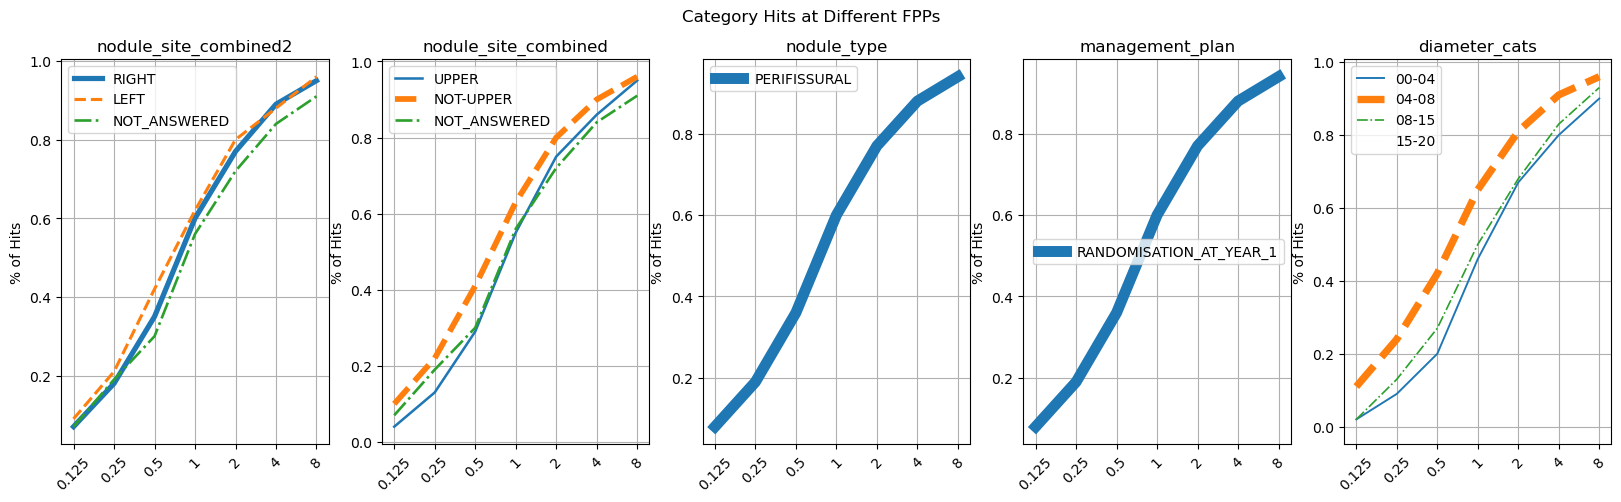

In [29]:

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

nodule_characteristics = {
    'nodule_site_combined2': ['RIGHT', 'LEFT', 'NOT_ANSWERED'],
    'nodule_site_combined': ['UPPER','NOT-UPPER', 'NOT_ANSWERED'],
    'nodule_type': ['SOLID', 'NON_SOLID', 'PART_SOLID', 'PERIFISSURAL', 'CALCIFIED'],
    'management_plan': ['RANDOMISATION_AT_YEAR_1','ALWAYS_SCAN_AT_YEAR_1', '3_MONTH_FOLLOW_UP_SCAN', 'URGENT_REFERRAL'],
    'diameter_cats': diameter_lbs,
}

for ivx, (var, order) in enumerate(nodule_characteristics.items()):
    annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv')
    # annotations = annotations[annotations['management_plan'] != 'RANDOMISATION_AT_YEAR_1']

    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []

    for idx, metadata in enumerate(missed_metadata):
        results.append(
            pd.crosstab(
                metadata[var], 
                metadata['miss'],
                normalize='index'
            )[False]
            .rename(f'{operating_points[idx]}')
            .reindex(order)
            
        )

    df = pd.concat(results, axis=1).fillna(0).round(2).merge(total_vc.to_frame(), left_index=True, right_index=True)

    display(df.T)


    line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
    weights = df.pop('Total Annotations')

    for isx, column in enumerate(df.T):    
            ax[ivx].plot(df.T[column], label=column, linestyle=line_styles[isx], linewidth=weights[isx]/100)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('% of Hits')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Hits at Different FPPs')
plt.show()

FEMALE          MALE  \
(PERIFISSURAL, RANDOMISATION_AT_YEAR_1)  299 (100.0%)  489 (100.0%)   
Total                                             299           489   

                                                Total  
(PERIFISSURAL, RANDOMISATION_AT_YEAR_1)  788 (100.0%)  
Total                                             788

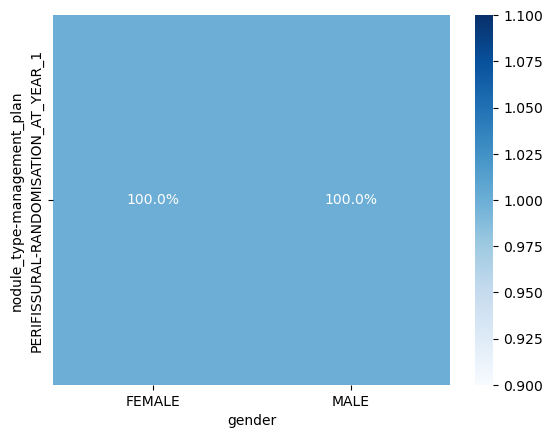

In [30]:
# Check what nodules have been missed by gender


missed_metadata_at_2fpps = missed_metadata[4]

def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

_ = crosstab_with_percentages(
    [missed_metadata_at_2fpps['nodule_type'], missed_metadata_at_2fpps['management_plan']],
    [missed_metadata_at_2fpps['gender']],
    table=True,
    heatmap=True)

In [31]:
scans = pd.read_csv(f'{workspace_path}/metadata/summit/perifissural_only/test_scans.csv')
predictions = pd.read_csv(detection_predictions_path)
annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/perifissural_only/annotations.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,    
    predictions=predictions,
    annotations=annotations
)

predictions: 201 at threshold: 0.97802734375
distance false positives: 139 at threshold: 0.97802734375
predictions: 444 at threshold: 0.9658203125
distance false positives: 292 at threshold: 0.9658203125
predictions: 870 at threshold: 0.94580078125
distance false positives: 589 at threshold: 0.94580078125
predictions: 1652 at threshold: 0.90771484375
distance false positives: 1185 at threshold: 0.90771484375
predictions: 2972 at threshold: 0.83349609375
distance false positives: 2370 at threshold: 0.83349609375
predictions: 5438 at threshold: 0.66552734375
distance false positives: 4749 at threshold: 0.66552734375
predictions: 10251 at threshold: 0.3583984375
distance false positives: 9507 at threshold: 0.3583984375


#### Examples of False Positives

summit-2323-kha_Y0_BASELINE_A already exists
summit-2323-kha_Y0_BASELINE_A - 260 239 91 5.625
False Positive: True
IoU False Positive: nan


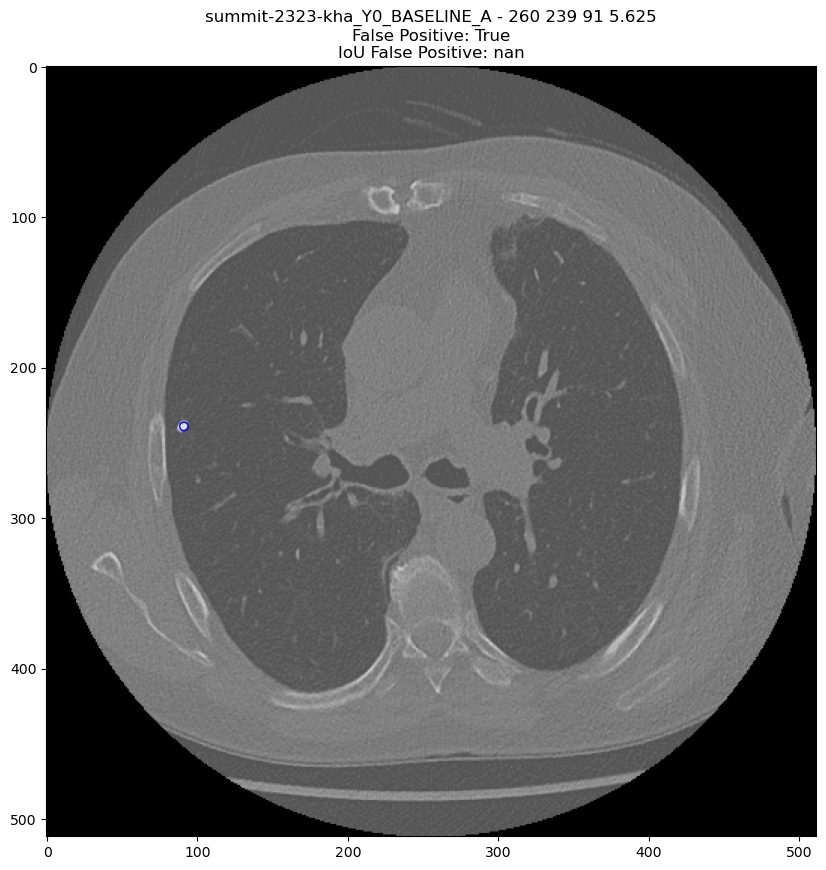

None
summit-5658-zmb_Y0_BASELINE_A - 204 290 432 5.009765625
False Positive: True
IoU False Positive: 0.0


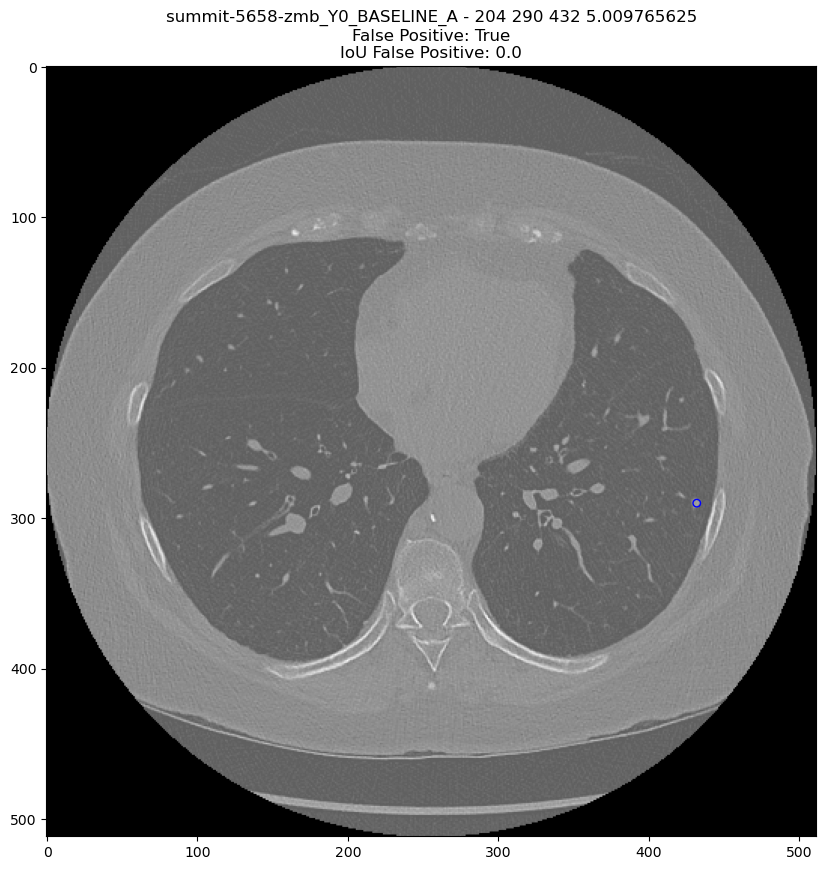

None
summit-7386-hbc_Y0_BASELINE_A - 232 343 420 5.234375
False Positive: True
IoU False Positive: nan


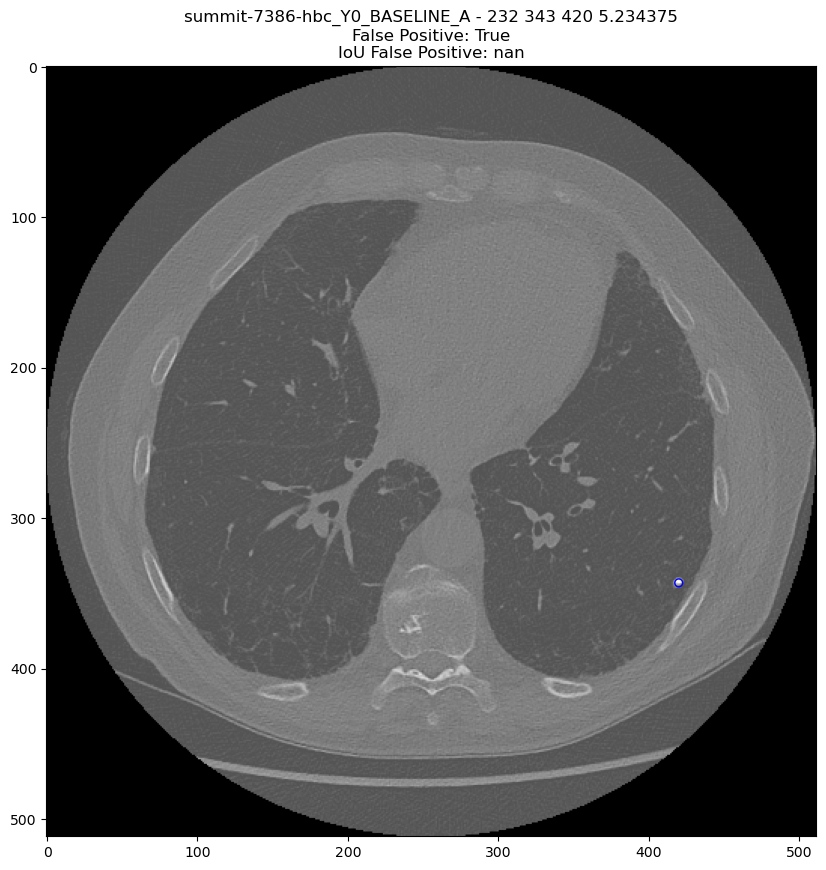

None
summit-6488-adj_Y0_BASELINE_A - 203 189 84 5.9765625
False Positive: True
IoU False Positive: nan


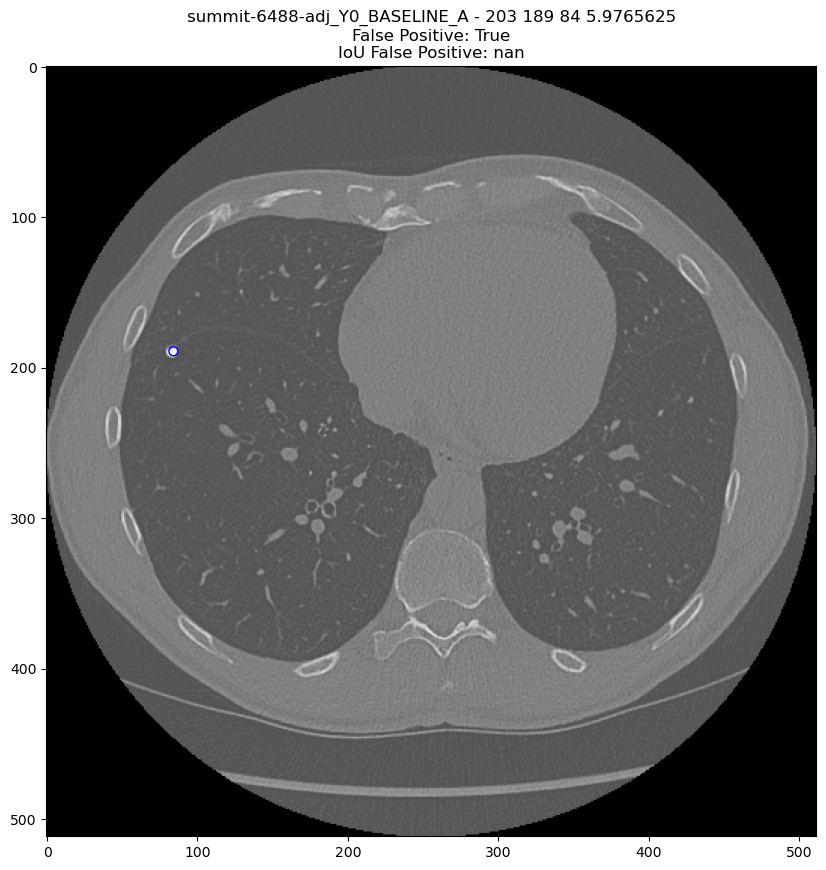

None
summit-8357-rrr_Y0_BASELINE_A - 284 287 400 5.009765625
False Positive: True
IoU False Positive: 0.0


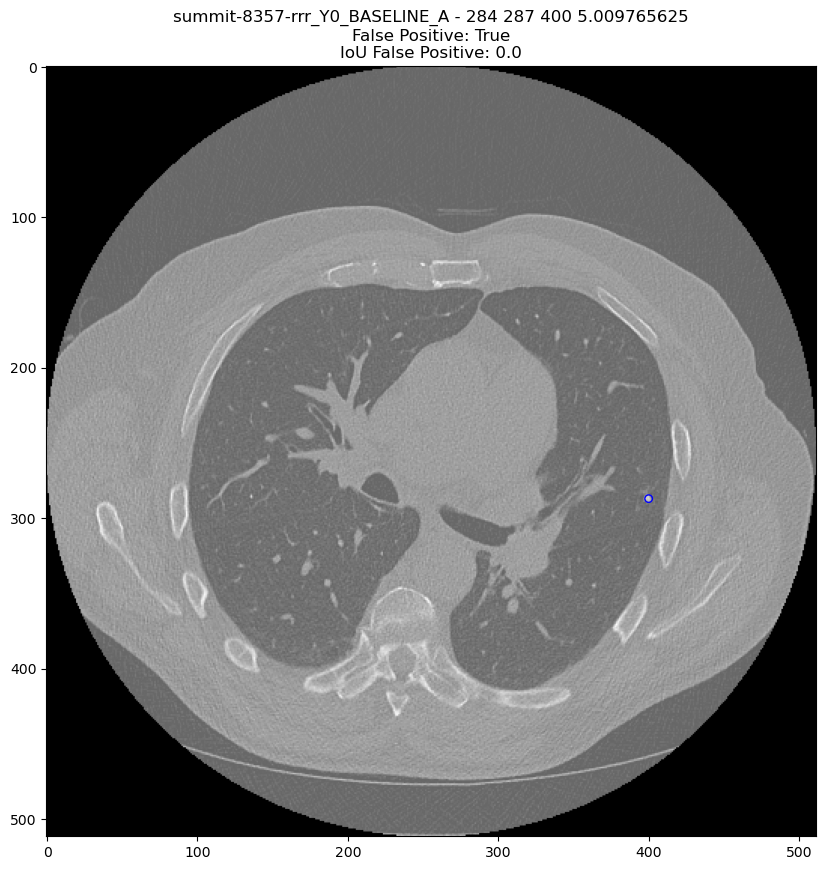

None
summit-7746-kyw_Y0_BASELINE_A - 304 230 142 5.0
False Positive: True
IoU False Positive: nan


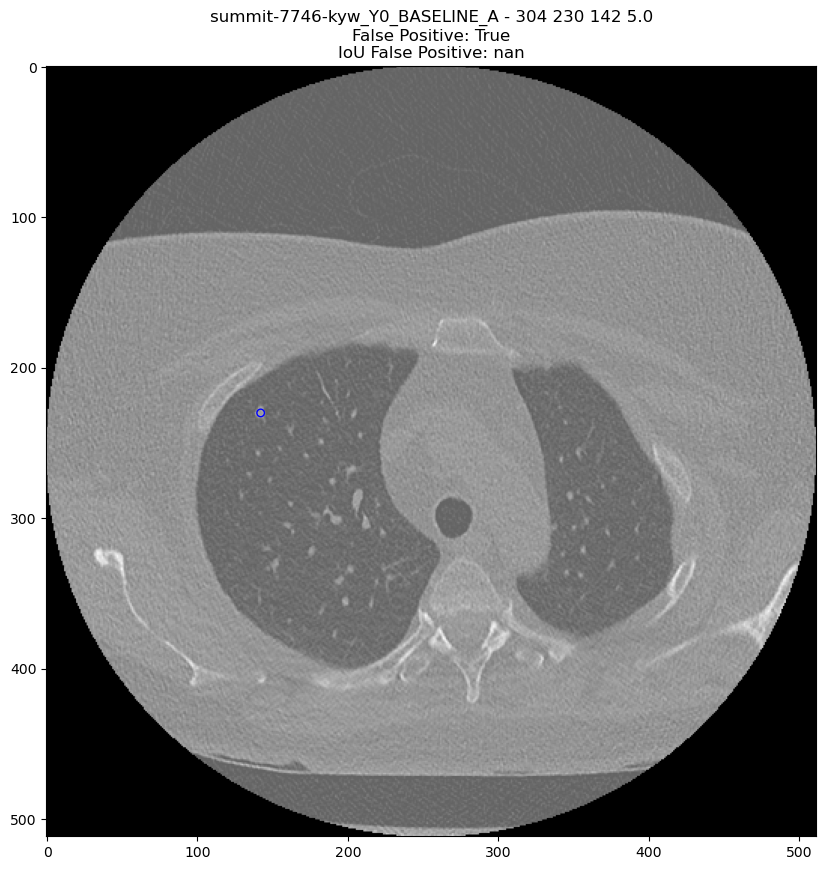

None
summit-6929-rhq_Y0_BASELINE_A - 115 323 67 5.0390625
False Positive: True
IoU False Positive: nan


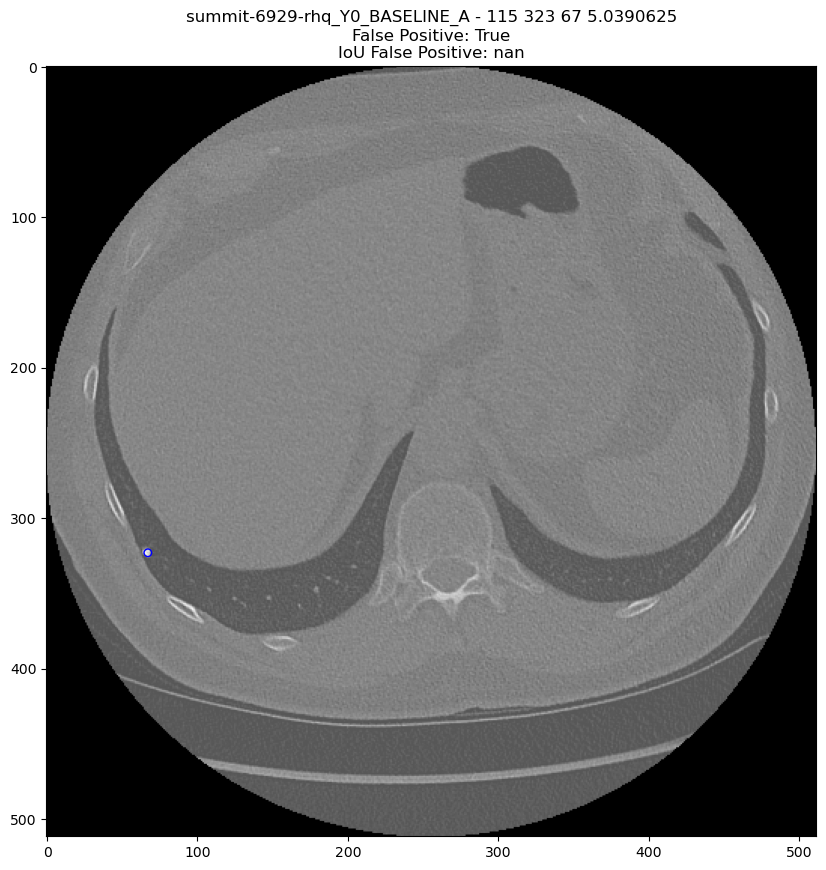

None
summit-3975-vqk_Y0_BASELINE_A - 412 326 150 5.3125
False Positive: True
IoU False Positive: 0.0


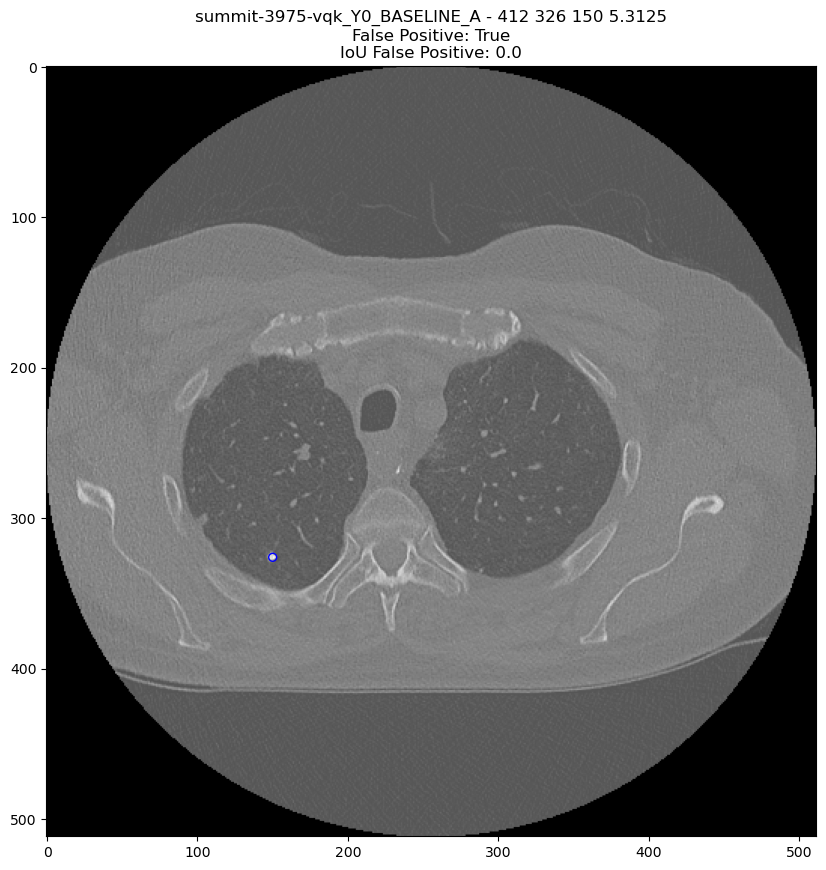

None
summit-9877-suh_Y0_BASELINE_A - 215 279 147 5.3125
False Positive: True
IoU False Positive: nan


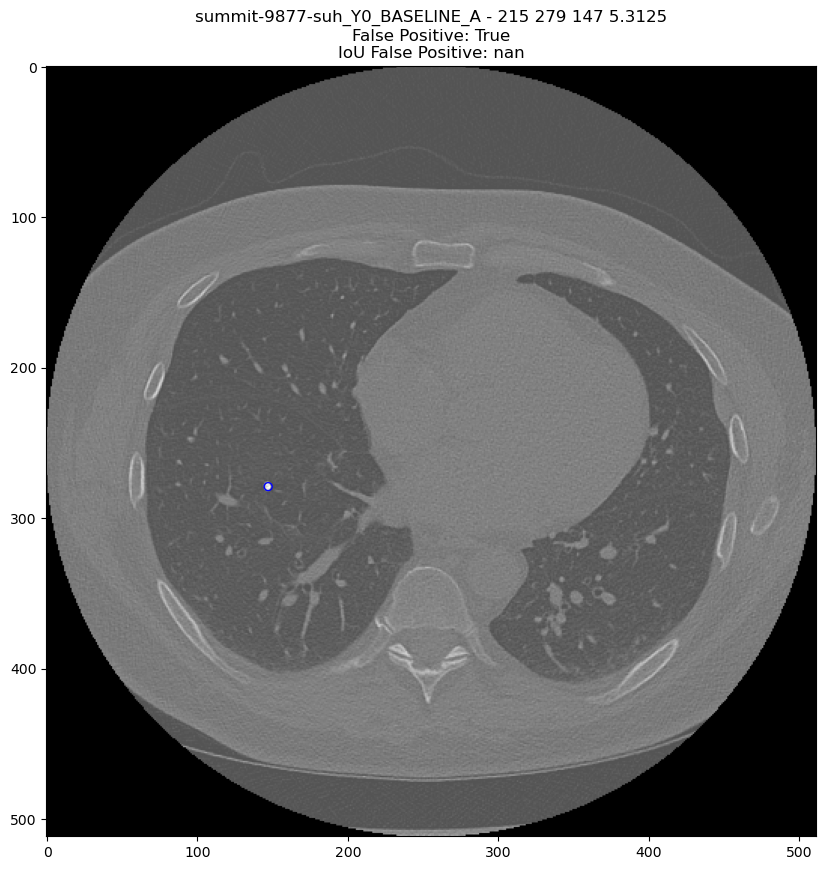

None
summit-2983-hrv_Y0_BASELINE_A - 225 249 106 9.140625
False Positive: True
IoU False Positive: nan


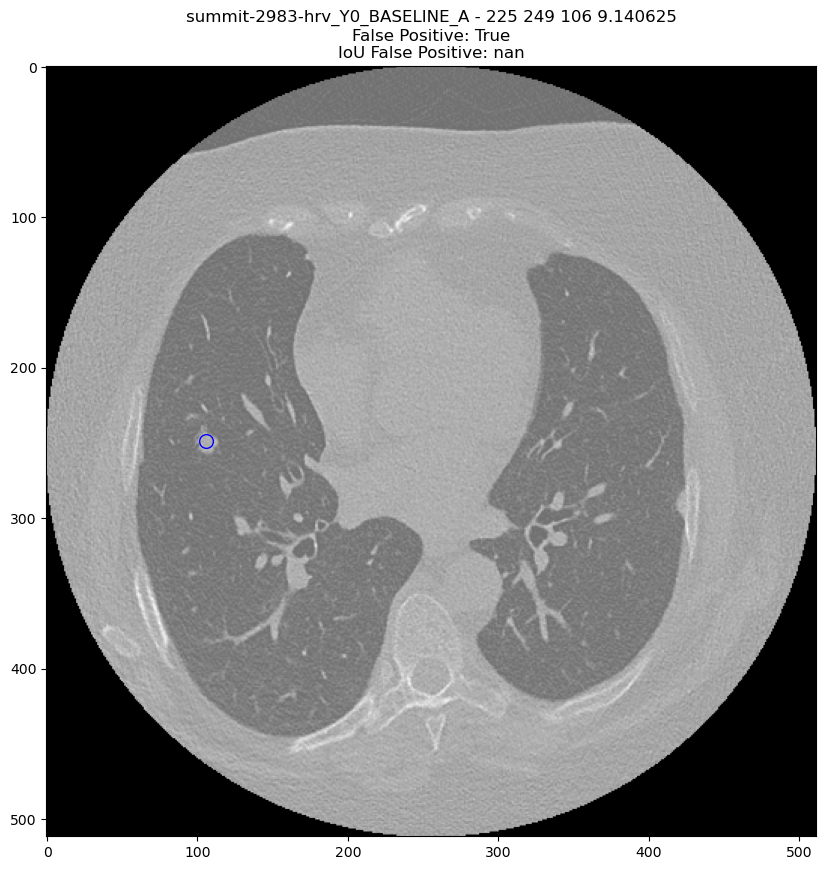

None
summit-5259-yqj_Y0_BASELINE_A - 248 256 137 5.078125
False Positive: True
IoU False Positive: 0.0


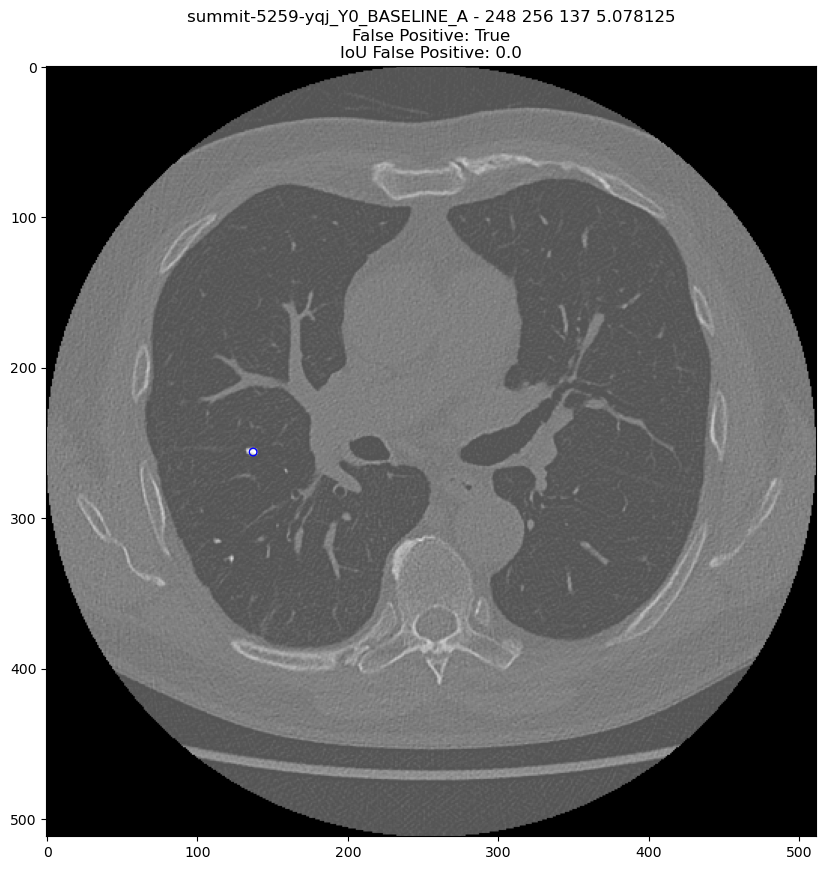

summit-5586-hfq_Y0_BASELINE_A already exists
summit-5586-hfq_Y0_BASELINE_A - 386 336 181 4.53125
False Positive: True
IoU False Positive: nan


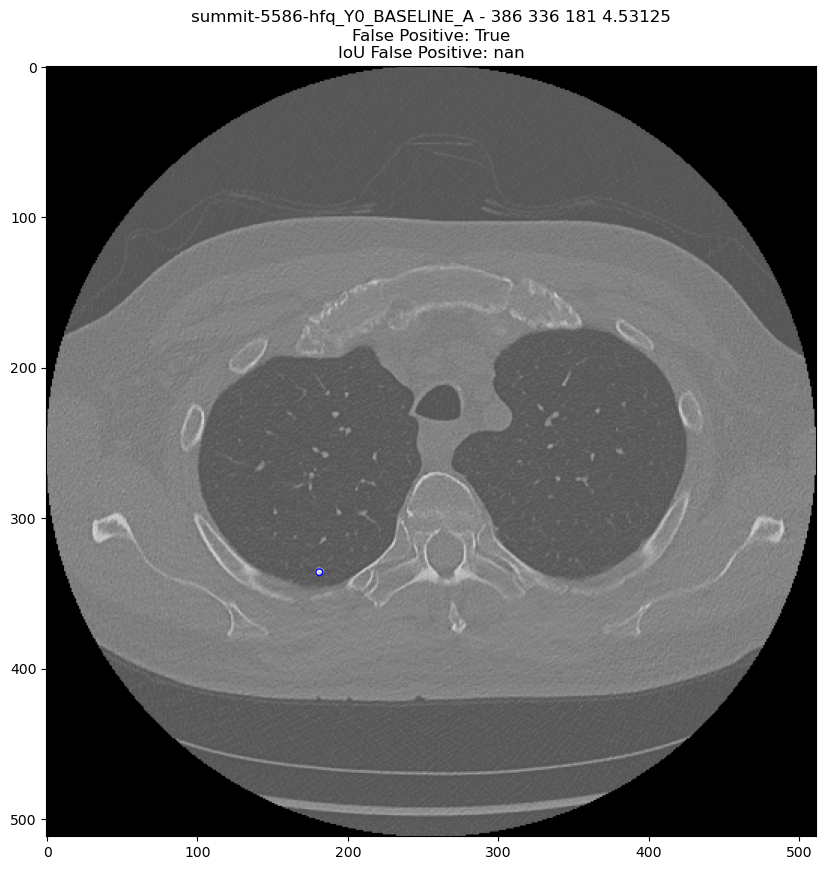

In [32]:
df = false_positives_fpps['0.125']

cnt = 0
for idx, row in df[df.distance_false_positive].sort_values(by='threshold', ascending=False).iterrows():
    scan_id = row['name']
    study_id = scan_id.split('_')[0]
    x = row['row']
    y = row['col']
    z = row['index']
    diameter = row['diameter']
    

    copy_scan_from_cluster(scan_id)
    
    scan = SummitScan.load_scan(f'{workspace_path}/data/summit/scans/{study_id}/{scan_id}.mhd')
    irc = xyz2irc([x, y, z], scan.origin, scan.voxel_size, scan.orientation)


    show_mhd_candidate_location(scan_id, scan.image, irc.row, irc.col, irc.index, diameter, row.distance_false_positive, row.iou_false_positive)
    cnt+=1
    if cnt == 12:
        break